In [75]:
# Imports
import autograd.numpy as np
from autograd import grad
from scipy.stats import truncnorm
import pprint
from autograd.misc.optimizers import rmsprop, adam

import matplotlib.pyplot as plt

In [2]:
# Utils: Numerically Stable, Vectorized implementations of util functions
def nprn(*size):
    return truncnorm.rvs(-2, 2, size=size)

def oneplus(x, limit=30.):
    """
    Numerically stable implementation: | log(1+exp(30)) - 30 | < 1e-10
    Constraint to [1, inf)
    """
#     limit = 30
#     x[x < limit] = np.log(1. + np.exp(x[x < limit]))
    x = np.log(1. + np.exp(x))
    return 1. + x

def sigmoid(x):
    """
    Constraint to [0, 1]
    """
    return 1. / (1. + np.exp(-x))

def softmax(x): # row-wise softmax
    res = np.exp(x - np.max(x, axis=1, keepdims=True))
    res /= np.sum(res, axis=1, keepdims=True)
    return res

def shift_cumprod(x):
    # solve dimension problem
    c = np.squeeze(x)
    slices = [1.]
    for i in range(1,len(c)):
        slices.append(np.prod(c[:i]))
    return np.array([slices])

def cos_sim(u, v):
    """
    Cosine similarity between u,v
    """
    n = np.dot(u,v)
    d = np.sqrt(np.dot(u,u) * np.dot(v,v))
    d += 1.e-20 # prevent undefined cos similarity at 0 from breaking the code
    return n / d

def d_tanh(x):
    """
    Derivative for tanh used for gradient calculation
    """
    y = np.tanh(x)
    return 1. - y * y

def d_sigmoid(x):
    """
    Derivative for sigmoid used for gradient calculation
    """
    y = sigmoid(x)
    return y * (1. - y)

def d_cos_sim(u, v):
    """
    Differentiate Cos Similarity with regard to u, switch order to calculate for v
    """
    n = np.dot(u, v)
    u_inner_prod = np.dot(u*u)
    d = np.sqrt(u_inner_prod * np.dot(v*v)) + 1.e-20 # deal with undefined cos sim for zero vec

    return v / d - (n / d) * (u / u_inner_prod)    
    

In [76]:
def unwrap(x):
    """
    Strip numpy values out of collections of Autograd values.
    """
    if isinstance(x,dict):
        r = {}
        for k, v in x.iteritems():
            if hasattr(v,'value'):
                r[k] = v.value
            else:
                r[k] = v
        return r
    elif all(isinstance(elt, dict) for elt in x):
        l = []
        for d in x:
            r = {}
            for k, v in d.iteritems():
                if hasattr(v,'value'):
                    r[k] = v.value
                else:
                    r[k] = v
            l.append(r)
        return l
    elif type(x) == np.numpy_extra.ArrayNode:
        return x.value
    else:
        return x
    

a = np.random.uniform(size=(2,10))

def display(arr):
    plt.imshow(arr, cmap='Greys')
#     plt.yticks([])
#     plt.xticks([])
    plt.show()

In [116]:
class DNCAccessor(object):
    """
    DNC Accessor, using autodiff, with batchsize=1
    """

    def __init__(self, R, N, W):

        self.R = R  # number of read heads
        self.N = N  # number of memory locations
        self.W = W  # number of columns in a memory location
         
        self.states = [self._init_state()]
        
    def _init_state(self):
        state = {}
        # linkage matrix
        state['L'] = np.zeros((self.N, self.N))
        # read_weighting
        state['rw'] = np.ones((self.R, self.N))*1e-6
        # precedence_weighting
        state['p'] = np.zeros((1, self.N))
        # write_weighting
        state['ww'] = np.ones((1, self.N))*1e-6
        # usage_vector
        state['u'] = np.ones((1, self.N))*1e-6
        return state
    
    def process_interface(self, interface):
        """
        Parse and process the input interface vector
        interface      - 1x(W*R+3W+5R+3) interface vector

        Return:
        rk_t         - RxW read keys
        rs_t         - Rx1 read strength
        wk_t         - 1xW write key
        ws_t         - 1x1 write strength
        e_t          - 1xW erase vector
        v_t          - 1xW write vector
        f_t          - Rx1 free gates
        ga_t         - 1x1 allocation gate
        gw_t         - 1x1 write gate
        pi_t         - Rx3 read modes
        """
        section_index = np.cumsum([self.R*self.W, self.R, self.W, 1, self.W, self.W, self.R, 1, 1, self.R*3])
        rk_t, rs_t, wk_t, ws_t, e_t, v_t, f_t, ga_t, gw_t, pi_t = np.split(interface, section_index[:-1], axis=1)
        rk_t = rk_t.reshape(self.R, self.W)
        rs_t = oneplus(rs_t.reshape(self.R, 1))
        wk_t = wk_t.reshape(1, self.W)
        ws_t = oneplus(ws_t)
        e_t = sigmoid(e_t.reshape(1, self.W))
        v_t = v_t.reshape(1, self.W)
        f_t = sigmoid(f_t.reshape(self.R, 1))
        ga_t = sigmoid(ga_t)
        gw_t = sigmoid(gw_t)
        pi_t = softmax(pi_t.reshape(self.R, 3))
        return rk_t, rs_t, wk_t, ws_t, e_t, v_t, f_t, ga_t, gw_t, pi_t  
        
    def content_weighting(self, mem, ks, betas):
        """
        The content based addressing method
        mem   - NxW memory     (N locations,  W entries)
        ks    - RxW lookup key (R heads, W entries)
        betas - 1xR lookup strength

        Return:
        RxN addressing matrix
        """
#         if len(ks.shape) < 2: ks = ks[np.newaxis, :] # deal with write head

        # Cosine Similarity
        n = np.dot(ks, mem.T)
        # einsum is fast: https://stackoverflow.com/questions/15616742/vectorized-way-of-calculating-row-wise-dot-product-two-matrices-with-scipy
        ks_inner_prod = np.einsum('ij,ij->i', ks, ks)
        mem_inner_prod = np.einsum('ij,ij->i', mem, mem)
        d = np.sqrt(np.einsum('i,j->ij', ks_inner_prod, mem_inner_prod)) + 1.e-20 # prevent undefined cos similarity at 0 from breaking the code
        sim = betas * (n / d)
        
        return softmax(sim)
    
    def usage_vec(self, f_t, rw_prev, ww_prev, u_prev):
        """
        Update usage vector
        f_t           - Rx1 free gates
        rw_prev       - RxN previous read weightings (R read heads, N locations)
        ww_prev       - 1xN previous write weighting (R read heads, 1 location)
        u_prev        - 1xN previous usage vector

        Return:
        1xN new usage vector
        """
        # psi is the 1xN retention vector
        psi = np.ones_like(rw_prev) - f_t * rw_prev
        psi = np.prod(psi, axis=0)
        # u is the usage vector
        u = (u_prev + ww_prev - u_prev * ww_prev) * psi
        return u

    def allocation_weighting(self, u):
        """
        Dynamic memory allocation weighting mechanism
        u_prev        - 1xN current usage vector

        Return:
        1xN alloc_weighting
        """
        # phi is the indices list that would sort u in ascending order
        phi = np.argsort(u, axis=1).squeeze()
        alloc_weighting = (np.ones_like(u) - u[:,phi]) * shift_cumprod(u[:,phi])
        return alloc_weighting

    def write_weighting(self, M_prev, wk_t, ws_t, u, gw_t, ga_t):
        """
        Write Weighting Mechanism
        
        M_prev        - NxW previous memory state
        wk_t          - 1xW write key
        ws_t          - 1x1 write strength
        f_t           - Rx1 free gates
        u             - 1xN current usage vector
        gw_t          - 1x1 write gate
        ga_t          - 1x1 allocation gate

        Return:
        1xN write_weighting 
        """
        c = self.content_weighting(M_prev, wk_t, ws_t)
        a = self.allocation_weighting(u)
        return gw_t * (ga_t * a + (1. - ga_t) * c)
        
    def temporal_memory_linkage(self, p_prev, ww, L_prev):
        """
        Temporal Linkage (TODO: Implement sparse link matrix)
        
        p_prev     - 1xN precedence weighting from last time step
        w_w        - 1xN write weighting
        L_prev     - NxN link matrix
        
        Return:
        1xN current precedence weighting
        NxN link matrix
        """
        # precedence weighting of the current timestep
        p_t = (1. - np.sum(ww)) * p_prev + ww
        L_t = (np.ones_like(L_prev) - (ww + ww.T)) * L_prev + ww * p_prev.T
        # Sanity check diag(L_t) should always be zero
        L_t = L_t - np.diag(np.diag(L_t))
        
        return p_t, L_t
    
    def read_weighting(self, M, rk_t, rs_t, rw_prev, L, pi_t):
        """
        Read Weighting
        
        M          - NxW memory matrix from current time step
        rk_t       - RxW read keys
        rs_t       - 1xR read strengths
        rw_prev    - RxN read weighting from previous time step
        L          - NxN link matrix from current time step
        pi_t       - Rx3 read modes
        
        Return:
        RxN Read Weighting
        """
        # content weighting
        c = self.content_weighting(M, rk_t, rs_t)
        # forward weighting
        f_t = np.dot(rw_prev, L)
        # backward weighting
        b_t = np.dot(rw_prev, L.T)
        # interpolates using read modes
        read_weighting = pi_t[:,0,np.newaxis] * b_t + pi_t[:,1,np.newaxis] * c + pi_t[:,2,np.newaxis] * f_t
        return read_weighting
    
    def read(self, M, rw):
        """
        Read from memory
        
        M          - NxW memory matrix from current time step
        rw         - RxN read weighting
        
        Return:
        RxW Stacked Read Vectors
        """
        return np.dot(rw, M)
    
    def write(self, M, e_t, v_t, ww):
        """
        Write to memory
        
        M          - NxW memory matrix from current time step
        e_t        - 1xW erase vector
        v_t        - 1xW write vector
        ww         - 1xN write weighting
        
        Return:
        NxW updated memory
        """
        return (np.ones_like(M) - np.dot(ww.T, e_t)) * M + np.dot(ww.T, v_t)
    
    def step_forward(self, M_prev, interface):
        """
        Forward inference given a inference vector and previous memory state
        M_prev         - NxW previous memory state
        interface      - 1x(W*R+3W+5R+3) interface vector
        
        Return:
        RxW Stacked Read Vectors
        """
        rk_t, rs_t, wk_t, ws_t, e_t, v_t, f_t, ga_t, gw_t, pi_t = self.process_interface(interface)
        _s = self.states[-1] # previous state
        L_prev, rw_prev, p_prev, ww_prev, u_prev = _s['L'], _s['rw'], _s['p'], _s['ww'], _s['u']
        
        u = self.usage_vec(f_t, rw_prev, ww_prev, u_prev)
#         print "write: "
        ww = self.write_weighting(M_prev, wk_t, ws_t, u, gw_t, ga_t)
        M = self.write(M_prev, e_t, v_t, ww)
        p, L = self.temporal_memory_linkage(p_prev, ww, L_prev)
#         print "read: "
        rw = self.read_weighting(M, rk_t, rs_t, rw_prev, L, pi_t)
        
        self.states.append(dict(zip(['u', 'ww', 'p', 'L', 'rw'],[u, ww, p, L, rw])))
        
        read_vec = self.read(M, rw)
        return M, read_vec

# Testing
# accessor = DNCAccessor(2,3,4) #R, N, W
# interface = nprn(1,2*4+3*4+5*2+3)
# memory = nprn(3,4)
# mem,vec = accessor.step_forward(memory, interface)
# print mem
# print vec
# print len(accessor.states)
# print accessor.states

def access_testing():
    def test_func(param, func):

        def foo(param):
            out = func(**param)
            res = 0
            for item in out:
                res = res + np.sum(item)
            return res

        print param
        print foo(param)
        print param
        grad_foo = grad(foo)
        print grad_foo(param)

    print "Test Interface" 
    accessor = DNCAccessor(2,3,4) #R, N, W
    param = {'interface':nprn(1,2*4+3*4+5*2+3)}
    test_func(param, accessor.process_interface)

    print "Test mem access" 
    accessor = DNCAccessor(2,3,4) #R, N, W
    param = {'mem':nprn(3,4), 'ks':nprn(2,4), 'betas':nprn(2,1)}
    test_func(param, accessor.content_weighting)
    
    param = {'mem':nprn(3,4), 'ks':nprn(2,4), 'betas':nprn(2,1)}
    normed_mem = param['mem'] / np.expand_dims(np.linalg.norm(param['mem'], axis=1), 1)
    normed_key = param['ks'] / np.expand_dims(np.linalg.norm(param['ks'], axis=1), 1)
    normed_sim = np.dot(normed_key, normed_mem.T) * param['betas']
    normed_sim = softmax(normed_sim)
    print "Assert Cosine Sim working: ", np.allclose(normed_sim, accessor.content_weighting(**param))
    
    print "Test usage vec"
    accessor = DNCAccessor(2,3,4) #R, N, W
    param = {'f_t':nprn(2,1), 'rw_prev':nprn(2,3), 'ww_prev':nprn(1,3), 'u_prev':nprn(1,3)}
    test_func(param, accessor.usage_vec)
    

    print "Test alloc weight"
    accessor = DNCAccessor(2,3,4) #R, N, W
    param = {'u':nprn(1,3)}
    test_func(param, accessor.allocation_weighting)

    print "Test write weighting"
    accessor = DNCAccessor(2,3,4) #R, N, W
    param = {'M_prev':nprn(3,4), 'wk_t':nprn(1,4), 'ws_t':nprn(1,1), 'u':nprn(1,3), 'gw_t':nprn(1,1), 'ga_t':nprn(1,1)}
    test_func(param, accessor.write_weighting)

    print "Test linkage"
    accessor = DNCAccessor(2,3,4) #R, N, W
    param = {'p_prev':nprn(1,3), 'ww':nprn(1,3), 'L_prev':nprn(3,3)}
    test_func(param, accessor.temporal_memory_linkage)

    print "Test read weighting"
    accessor = DNCAccessor(2,3,4) #R, N, W
    param = {'M':nprn(3,4), 'rk_t':nprn(2,4), 'rs_t':nprn(2,1), 'rw_prev':nprn(2,3), 'L':nprn(3,3), 'pi_t':nprn(2,3)}
    test_func(param, accessor.read_weighting)

    print "Test step forward"
    accessor = DNCAccessor(2,3,4) #R, N, W
    param = {'M_prev':nprn(3,4), 'interface':nprn(1,2*4+3*4+5*2+3)}
    test_func(param, accessor.step_forward)
    
access_testing()

Test Interface
{'interface': array([[  1.17641278e+00,   5.12346378e-01,   2.45215104e-01,
          9.99077909e-01,   7.17149422e-01,   4.05321135e-01,
         -2.91003182e-01,   2.94664181e-01,   4.66777129e-01,
         -1.26342356e+00,   2.57482200e-01,   7.49835709e-01,
         -7.46771589e-01,  -7.36769963e-01,  -1.84431335e-01,
         -9.92014188e-01,   5.95341947e-03,   1.25366643e+00,
          1.74376278e+00,  -8.63142659e-01,   7.98825314e-01,
          6.01827529e-03,  -1.20631632e+00,  -5.40779972e-01,
          1.70128135e-03,   2.46266079e-01,  -5.39090261e-01,
         -7.89593845e-01,  -8.80599916e-02,  -1.18202855e-01,
          1.09482368e+00,  -2.46078013e-01,   1.44745610e+00]])}
13.3251934089
{'interface': array([[  1.17641278e+00,   5.12346378e-01,   2.45215104e-01,
          9.99077909e-01,   7.17149422e-01,   4.05321135e-01,
         -2.91003182e-01,   2.94664181e-01,   4.66777129e-01,
         -1.26342356e+00,   2.57482200e-01,   7.49835709e-01,
         -

In [97]:
class DNC(object):
    """
    DNC with LSTM controller, using autodiff, with batchsize=1
    """

    def __init__(self, input_size, output_size, hidden_size, R, N, W):

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.R = R
        self.N = N  # the number of memory locations
        self.W = W # the number of columns in a memory location
        
        self.accessor = DNCAccessor(R, N, W)
        self.states = None
     
    def _init_params(self):
        p = {} # maps parameter names to tensors
        
        # single layer LSTMController weights
        p['W_i'] = nprn(self.input_size + self.R * self.W + self.hidden_size, self.hidden_size)*0.1
        p['b_i'] = np.zeros((1, self.hidden_size))
        p['W_f'] = nprn(self.input_size + self.R * self.W + self.hidden_size, self.hidden_size)*0.1
        p['b_f'] = np.zeros((1, self.hidden_size))
        p['W_s'] = nprn(self.input_size + self.R * self.W + self.hidden_size, self.hidden_size)*0.1
        p['b_s'] = np.zeros((1, self.hidden_size))
        p['W_o'] = nprn(self.input_size + self.R * self.W + self.hidden_size, self.hidden_size)*0.1
        p['b_o'] = np.zeros((1, self.hidden_size))
        
        p['W_y'] = nprn(self.hidden_size, self.output_size)*0.1
        p['W_xi'] = nprn(self.hidden_size, self.R*self.W + 3*self.W + 5*self.R + 3)*0.1
        
        # output weights
        p['W_r'] = nprn(self.R*self.W, self.output_size)*0.1
        return p

    def _init_state(self):
        state = {}
        # not initializing to zero can prevent nan in loss
        # memory matrix
        state['M'] = np.ones((self.N, self.W))*1e-6
        # lstm hidden state
        state['h'] = np.zeros((1, self.hidden_size))
        # lstm cell state
        state['s'] = np.zeros((1, self.hidden_size))
        # read vector
        state['rv'] = np.ones((self.R, self.W))*1e-6
        self.states = [state]
    
    def lstm_step_forward(self, params, x_t, rv_prev, h_prev, s_prev):
        """
        LSTM step forward

        x_t        - 1xX input
        rv_prev    - RxW read vector from prev step
        h_prev     - 1xH previous hidden state
        s_prev     - 1xH previous cell state
        params     - lstm parameter dictionary, included here for the purpose of backprop

        Return:
        h_t        - 1xH current hidden state
        s_t        - 1xH current cell state
        v_t        - 1xY output vector
        interface  - 1x(W*R+3W+5R+3) interface vector
        """
        X_t = np.concatenate((x_t, rv_prev.reshape(1,-1), h_prev), axis=1)
        i_t = sigmoid(np.dot(X_t, params['W_i']) + params['b_i'])
        f_t = sigmoid(np.dot(X_t, params['W_f']) + params['b_f'])
        s_t = f_t * s_prev + i_t * np.tanh(np.dot(X_t, params['W_s']) + params['b_s'])
        o_t = sigmoid(np.dot(X_t, params['W_o']) + params['b_o'])
        h_t = o_t * np.tanh(s_t)

        v_t = np.dot(h_t, params['W_y'])
        interface = np.dot(h_t, params['W_xi'])
        return h_t, s_t, v_t, interface
    
    def step_forward(self, params, x_t):
        if self.states is None: self._init_state()
        
        _s = self.states[-1]
        M_prev, h_prev, s_prev, rv_prev = _s['M'], _s['h'], _s['s'], _s['rv']
        
        h_t, s_t, v_t, interface = self.lstm_step_forward(params, x_t, rv_prev, h_prev, s_prev)
#         print "interface!!!: ", interface
        M_t, rv_t = self.accessor.step_forward(M_prev, interface)
        state = dict(zip(['M', 'h', 's', 'rv'], [M_t, h_t, s_t, rv_t]))
        self.states.append(state)
        
        out = v_t + np.dot(rv_t.reshape(1,-1), params['W_r'])
        return out
        
# Test
dnc = DNC(input_size=10, output_size=10, hidden_size=1, R=1, N=10, W=1)
dnc_params = dnc._init_params()
inpt = np.array([[0., 1., 0., 0., 1., 0., 0., 1., 0., 1.]])
print inpt
print dnc.step_forward(dnc_params, inpt)

[[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  1.]]
[[ 0.00149587  0.00267741 -0.00191709  0.00183955 -0.00945387 -0.00220079
   0.0062654  -0.00465918  0.00598846  0.00359862]]


In [98]:
class DNCFF(object):
    """
    DNC with feedforward controller, using autodiff, with batchsize=1
    """

    def __init__(self, input_size, output_size, hidden_size, R, N, W):

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.R = R
        self.N = N  # the number of memory locations
        self.W = W # the number of columns in a memory location
        
        self.accessor = DNCAccessor(R, N, W)
        self.states = None

    def _init_params(self):
        p = {} # maps parameter names to tensors
        
        # two layer feedforward weights
        p['W_1'] = nprn(self.input_size + self.R * self.W, self.hidden_size)*0.1
        p['b_1'] = np.zeros((1, self.hidden_size))
        p['W_2'] = nprn(self.hidden_size, self.output_size)*0.1
        p['b_2'] = np.zeros((1, self.output_size))
        
        p['W_y'] = nprn(self.output_size, self.output_size)*0.1
        p['W_xi'] = nprn(self.output_size, self.R*self.W + 3*self.W + 5*self.R + 3)*0.1
        
        # output weights
        p['W_r'] = nprn(self.R*self.W, self.output_size)*0.1
        return p
    
    def _init_state(self):
        state = {}
        # not initializing to zero can prevent nan in loss
        # memory matrix
        state['M'] = np.ones((self.N, self.W))*1e-6 # be careful about initialization, otherwise cosine similarity will blow up during backprop
        # read vector
        state['rv'] = np.ones((self.R, self.W))*1e-6
        self.states = [state]
    
    def nn_step_forward(self, params, x_t, rv_prev):
        """
        nn step forward

        x_t        - 1xX input
        rv_prev    - RxW read vector from prev step
        params     - lstm parameter dictionary, included here for the purpose of backprop

        Return:
        v_t        - 1xY output vector
        interface  - 1x(W*R+3W+5R+3) interface vector
        """
        X_t = np.concatenate((x_t, rv_prev.reshape(1,-1)), axis=1)
        h_1 = np.dot(X_t, params['W_1']) + params['b_1']
        h_1 = np.tanh(h_1)
        o_1 = np.dot(h_1, params['W_2']) + params['b_2']
        o_1 = np.tanh(o_1)

        v_t = np.dot(o_1, params['W_y'])
        interface = np.dot(o_1, params['W_xi'])
        return v_t, interface
    
    def step_forward(self, params, x_t):
        if self.states is None: self._init_state()
        
        _s = self.states[-1]
        M_prev, rv_prev = _s['M'], _s['rv']
        
        v_t, interface = self.nn_step_forward(params, x_t, rv_prev)
#         print "interface!!!: ", interface
        M_t, rv_t = self.accessor.step_forward(M_prev, interface)
        state = dict(zip(['M', 'rv'], [M_t, rv_t]))
        self.states.append(state)
        
        out = v_t + np.dot(rv_t.reshape(1,-1), params['W_r'])
        return out
    

        
# Test
dnc = DNCFF(input_size=10, output_size=10, hidden_size=32, R=1, N=10, W=1)
dnc_params = dnc._init_params()
inpt = np.array([[0., 1., 0., 0., 1., 0., 0., 1., 0., 1.]])
print inpt
print dnc.step_forward(dnc_params, inpt)

[[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  1.]]
[[ 0.00464153  0.00641723  0.0394425  -0.00478885 -0.05513979 -0.06267131
   0.03785765 -0.03950848  0.05012604  0.02907373]]


In [99]:
# Training utils

def copy_sequence(seq_len, vec_size):
    """
    Implements the copy task - section 4.1 from the paper.
    Returns inputs, outputs
    where inputs is a length 2 * seq_len + 2 sequence of vec_size + 2 vecs
    and outputs is a length 2 * seq_len + 2 sequence of vec_size vecs
    Inputs starts with a start bit, then the seq to be copied, then and end bit, then 0s.
    outputs is 0s until after inputs has the end bit, then it's the first sequence, but without
    the extra channels for start and stop bits.
    """
    input_size = vec_size + 2
    length  = seq_len * 2 + 2
    inputs  = np.zeros((length,input_size),dtype=np.uint8)
    outputs = np.zeros((length,vec_size),dtype=np.uint8)

    in_sequence = np.random.randint(2, size=(seq_len, input_size))
    in_sequence[:,-2:] = 0
    out_sequence = in_sequence[:,:-2]

    # set start bit in inputs
    start_vec = np.zeros(input_size)
    start_vec[-2] = 1
    inputs[0] = start_vec

    # set the pattern bits in inputs
    inputs[1:seq_len+1] = in_sequence

    # set stop bit in inputs
    stop_vec = np.zeros(input_size)
    stop_vec[-1] = 1
    inputs[seq_len+1] = stop_vec

    # set all the bits in outputs
    outputs[seq_len+2:] = out_sequence
    return inputs, outputs, seq_len

# i, o, seqlen = copy_sequence(3, 24)
# print i.shape
# print i[1]
# print o.shape
# # print o
# print seqlen
# print i[np.newaxis, 1]

Training DNC...
('Iteration', 0, 'Train loss:', <autograd.numpy.numpy_boxes.ArrayBox object at 0x7fc55b4a7320>)
Test loss:  Autograd ArrayBox with value 145.713152402
Target


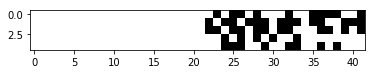

Predicted


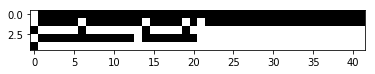

L
Autograd ArrayBox with value [[ 0.          0.10763355  0.08256162  0.06585542  0.05567604  0.04981203
   0.04654631  0.04476368  0.04379696  0.04326821]
 [ 0.10758842  0.          0.06991565  0.05753206  0.04959585  0.04488403
   0.04221553  0.04074644  0.03994703  0.03950917]
 [ 0.08249936  0.06989128  0.          0.04943527  0.04344296  0.03977719
   0.03766589  0.03649371  0.03585396  0.03550337]
 [ 0.06579299  0.05750004  0.04942472  0.          0.03825503  0.03537186
   0.03368823  0.03274713  0.03223245  0.0319505 ]
 [ 0.05562053  0.04956552  0.04343153  0.03825366  0.          0.03215171
   0.03075028  0.02996327  0.02953233  0.02929645]
 [ 0.04976448  0.04485862  0.03976916  0.03537377  0.03215515  0.
   0.02884651  0.02815271  0.02777255  0.02756461]
 [ 0.0465055   0.04219517  0.03766214  0.03369449  0.03075826  0.02885112
   0.          0.02707522  0.02672414  0.02653221]
 [ 0.04472818  0.04073049  0.03649394  0.03275742  0.0299754   0.02816149
   0.02707939  0.          0

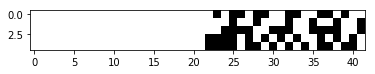

Predicted


ValueError: object too deep for desired array

L
Autograd ArrayBox with value [[ 0.          0.10748987  0.08253008  0.06588588  0.05572751  0.0498611
   0.046582    0.04478105  0.04379741  0.04325745]
 [ 0.10746652  0.          0.06992763  0.05759174  0.04967306  0.04495766
   0.04227519  0.04078754  0.03997072  0.03952099]
 [ 0.0824994   0.0699173   0.          0.04954261  0.04356648  0.03989647
   0.03777038  0.03657914  0.03592136  0.03555806]
 [ 0.06585662  0.05757969  0.04953977  0.          0.03843173  0.03554753
   0.03385032  0.03289082  0.03235835  0.03206344]
 [ 0.05570265  0.04966295  0.04356427  0.03843191  0.          0.03236281
   0.03095039  0.03014656  0.02969881  0.0294503 ]
 [ 0.04984068  0.04495027  0.03989588  0.03554881  0.03236376  0.
   0.02905363  0.02834434  0.02794828  0.02772815]
 [ 0.04656506  0.04227017  0.03777135  0.03385274  0.03095231  0.02905455
   0.          0.02725625  0.02688988  0.02668609]
 [ 0.0447665   0.04078424  0.03658129  0.03289413  0.03014922  0.02834595
   0.02725693  0.          0.

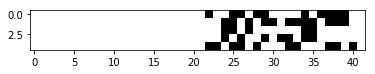

Predicted


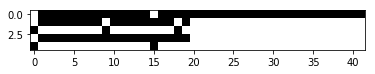

L
Autograd ArrayBox with value [[ 0.          0.10746644  0.08253062  0.06589547  0.05573748  0.04986824
   0.04658597  0.04478252  0.04379712  0.04325589]
 [ 0.10744602  0.          0.06993788  0.05760582  0.04968503  0.0449656
   0.04227937  0.04078893  0.03997024  0.03951925]
 [ 0.08250325  0.06992796  0.          0.04955822  0.0435782   0.03990347
   0.03777342  0.03657938  0.03591977  0.03555529]
 [ 0.06586877  0.05759345  0.04955464  0.          0.0384404   0.03555168
   0.03385084  0.0328888   0.03235471  0.03205876]
 [ 0.05571421  0.04967368  0.04357439  0.03843975  0.          0.03236299
   0.03094744  0.03014144  0.0296923   0.02944291]
 [ 0.04984859  0.04495624  0.03990064  0.03555155  0.03236337  0.
   0.02904729  0.02833614  0.02793888  0.02771799]
 [ 0.04656922  0.04227187  0.03777172  0.03385147  0.03094843  0.02904786
   0.          0.02724559  0.02687816  0.02667369]
 [ 0.04476778  0.04078283  0.0365786   0.0328901   0.03014297  0.0283372
   0.02724608  0.          0.0

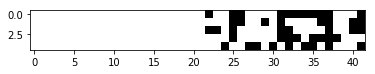

Predicted


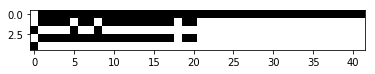

L
Autograd ArrayBox with value [[ 0.          0.10746914  0.08252916  0.06589301  0.05573552  0.04986713
   0.04658556  0.04478254  0.04379732  0.04325614]
 [ 0.10744875  0.          0.06993476  0.05760338  0.04968413  0.04496608
   0.04228081  0.04079091  0.03997245  0.03952153]
 [ 0.08250228  0.06992561  0.          0.04955768  0.04357974  0.03990659
   0.03777753  0.03658401  0.03592463  0.03556021]
 [ 0.06586726  0.05759249  0.04955491  0.          0.03844467  0.03555736
   0.03385734  0.03289572  0.0323618   0.03206589]
 [ 0.05571348  0.04967469  0.04357723  0.03844453  0.          0.03237057
   0.03095565  0.03014995  0.02970092  0.02945155]
 [ 0.04984888  0.04495885  0.03990529  0.03555797  0.03237118  0.
   0.0290565   0.02834557  0.02794838  0.02772749]
 [ 0.04657029  0.04227552  0.03777745  0.03385881  0.03095698  0.02905717
   0.          0.02725548  0.02688808  0.02668359]
 [ 0.04476933  0.04078705  0.03658488  0.03289789  0.03015185  0.02834677
   0.027256    0.          0

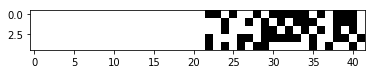

Predicted


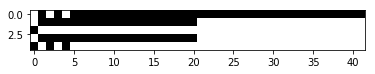

L
Autograd ArrayBox with value [[ 0.          0.10748075  0.08252971  0.06588905  0.05573108  0.0498638
   0.04658363  0.04478179  0.04379746  0.04325696]
 [ 0.10745861  0.          0.06993085  0.05759686  0.0496778   0.04496114
   0.04227738  0.04078872  0.03997115  0.03952089]
 [ 0.08250055  0.06992093  0.          0.04954905  0.04357186  0.03990026
   0.03777272  0.0365804   0.03592187  0.03555804]
 [ 0.06586117  0.05758513  0.04954612  0.          0.03843653  0.03555069
   0.03385206  0.03289153  0.03235836  0.03206297]
 [ 0.05570729  0.04966774  0.04356931  0.03843646  0.          0.0323646
   0.0309509   0.03014613  0.02969776  0.02944882]
 [ 0.04984417  0.04495354  0.03989908  0.0355515   0.03236533  0.
   0.02905275  0.02834262  0.027946    0.02772549]
 [ 0.04656727  0.04227194  0.03777292  0.03385386  0.03095244  0.02905351
   0.          0.02725343  0.02688655  0.02668241]
 [ 0.04476769  0.04078486  0.03658167  0.0328941   0.03014832  0.02834398
   0.02725402  0.          0.0

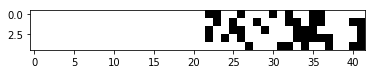

Predicted


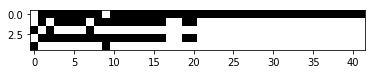

L
Autograd ArrayBox with value [[ 0.          0.10746145  0.08252892  0.06589574  0.05573852  0.04986933
   0.0465868   0.04478298  0.0437972   0.04325563]
 [ 0.1074422   0.          0.06993747  0.05760767  0.04968819  0.04496917
   0.04228288  0.04079218  0.03997316  0.03952187]
 [ 0.08250349  0.06992873  0.          0.04956298  0.04358442  0.03991025
   0.03778022  0.03658596  0.03592609  0.03556134]
 [ 0.06587131  0.05759719  0.04956026  0.          0.03844925  0.035561
   0.03386014  0.0328979   0.03236355  0.03206737]
 [ 0.05571754  0.04967901  0.04358188  0.03844905  0.          0.03237372
   0.03095811  0.03015188  0.0297025   0.02945289]
 [ 0.04985189  0.04496204  0.03990882  0.0355615   0.03237428  0.
   0.02905841  0.02834703  0.02794954  0.02772845]
 [ 0.04657215  0.04227756  0.03777993  0.03386144  0.03095933  0.02905904
   0.          0.02725647  0.02688881  0.02668414]
 [ 0.04477026  0.0407882   0.03658658  0.03289985  0.03015366  0.02834817
   0.02725697  0.          0.0

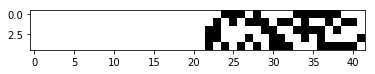

Predicted


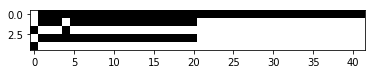

L
Autograd ArrayBox with value [[ 0.          0.10748396  0.08253062  0.06588873  0.05573035  0.0498631
   0.04658312  0.04478148  0.04379733  0.04325696]
 [ 0.10746113  0.          0.06993106  0.05759586  0.04967613  0.04495923
   0.04227547  0.0407869   0.03996944  0.03951927]
 [ 0.08250037  0.06992055  0.          0.04954692  0.04356901  0.03989705
   0.0377694   0.03657709  0.03591862  0.03555484]
 [ 0.06585959  0.05758318  0.04954355  0.          0.03843265  0.03554651
   0.03384778  0.03288724  0.0323541   0.03205874]
 [ 0.05570529  0.04966493  0.04356578  0.03843232  0.          0.03235983
   0.03094605  0.03014129  0.02969295  0.02944405]
 [ 0.04984223  0.04495043  0.03989508  0.03554693  0.03236042  0.
   0.02904764  0.02833753  0.02794095  0.02772048]
 [ 0.04656556  0.04226882  0.03776876  0.03384911  0.03094738  0.02904833
   0.          0.02724826  0.02688142  0.02667731]
 [ 0.04476621  0.04078183  0.03657749  0.03288931  0.03014324  0.02833879
   0.02724881  0.          0.

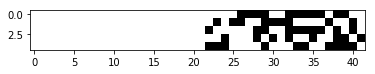

Predicted


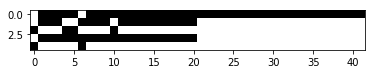

L
Autograd ArrayBox with value [[ 0.          0.10747742  0.08252886  0.06588952  0.05573198  0.04986467
   0.0465843   0.04478221  0.04379765  0.04325694]
 [ 0.10745586  0.          0.0699309   0.05759811  0.04967958  0.04496296
   0.04227903  0.04079014  0.03997235  0.0395219 ]
 [ 0.08250062  0.06992147  0.          0.04955158  0.0435748   0.03990316
   0.0377754   0.03658283  0.03592407  0.03556006]
 [ 0.06586269  0.05758713  0.04954894  0.          0.03844032  0.03555437
   0.03385549  0.03289468  0.03236128  0.03206571]
 [ 0.05570924  0.04967034  0.04357263  0.03844036  0.          0.03236857
   0.03095461  0.03014958  0.02970099  0.02945189]
 [ 0.04984605  0.04495617  0.03990237  0.03555531  0.03236932  0.
   0.02905639  0.02834603  0.0279492   0.02772854]
 [ 0.0465689   0.04227437  0.03777596  0.03385737  0.03095615  0.02905714
   0.          0.02725663  0.02688956  0.02668528]
 [ 0.04476903  0.04078702  0.03658442  0.03289731  0.03015174  0.02834735
   0.02725719  0.          0

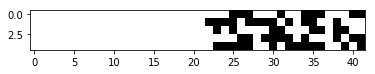

Predicted


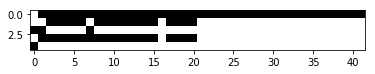

L
Autograd ArrayBox with value [[ 0.          0.10748918  0.08252996  0.06588601  0.05572773  0.04986134
   0.04658228  0.04478138  0.04379778  0.04325779]
 [ 0.10746571  0.          0.06992781  0.05759191  0.04967295  0.04495728
   0.04227464  0.04078692  0.03997007  0.0395203 ]
 [ 0.0824991   0.06991729  0.          0.04954235  0.04356544  0.03989475
   0.03776821  0.03657673  0.03591883  0.03555545]
 [ 0.06585656  0.05757947  0.04953919  0.          0.03842928  0.03554422
   0.03384645  0.03288663  0.03235399  0.03205898]
 [ 0.05570269  0.04966229  0.04356265  0.03842916  0.          0.03235808
   0.0309451   0.03014094  0.02969302  0.02944441]
 [ 0.04984076  0.04494925  0.03989341  0.03554501  0.03235883  0.
   0.02904733  0.02833774  0.02794151  0.02772129]
 [ 0.04656519  0.04226893  0.03776833  0.03384826  0.03094669  0.02904813
   0.          0.02724904  0.02688252  0.02667864]
 [ 0.04476671  0.0407829   0.03657799  0.03288927  0.03014322  0.02833916
   0.02724966  0.          0

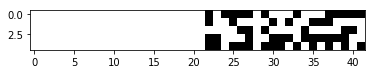

Predicted


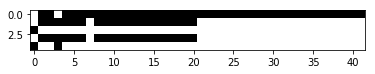

L
Autograd ArrayBox with value [[ 0.          0.10747983  0.08252915  0.06588886  0.05573112  0.04986397
   0.04658385  0.044782    0.04379764  0.0432571 ]
 [ 0.1074579   0.          0.0699303   0.05759682  0.04967818  0.04496177
   0.04227813  0.04078951  0.03997194  0.03952166]
 [ 0.08250039  0.06992064  0.          0.04954951  0.04357274  0.03990138
   0.03777396  0.03658169  0.03592316  0.03555932]
 [ 0.06586149  0.05758553  0.04954678  0.          0.03843789  0.03555223
   0.03385368  0.03289316  0.03235998  0.03206456]
 [ 0.0557079   0.04966865  0.04357049  0.03843793  0.          0.0323664
   0.03095273  0.03014796  0.02969956  0.0294506 ]
 [ 0.04984493  0.04495475  0.03990056  0.0355532   0.03236718  0.
   0.02905466  0.02834452  0.02794786  0.02772733]
 [ 0.04656808  0.0422733   0.03777454  0.03385565  0.03095434  0.02905545
   0.          0.02725533  0.02688841  0.02668424]
 [ 0.04476849  0.04078627  0.03658334  0.03289591  0.03015022  0.02834591
   0.02725592  0.          0.

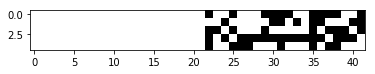

Predicted


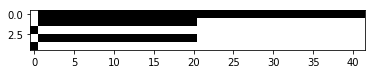

L
Autograd ArrayBox with value [[ 0.          0.10748345  0.08252928  0.06588757  0.05572968  0.04986284
   0.04658312  0.0447816   0.0437975   0.04325716]
 [ 0.10746114  0.          0.06992905  0.05759492  0.04967654  0.04496068
   0.04227757  0.04078935  0.03997206  0.03952198]
 [ 0.08250007  0.06991934  0.          0.04954744  0.04357133  0.03990076
   0.037774    0.03658219  0.03592397  0.03556034]
 [ 0.06585983  0.05758372  0.04954487  0.          0.03843721  0.03555241
   0.03385454  0.0328945   0.03236163  0.03206642]
 [ 0.0557062   0.04966726  0.04356943  0.03843745  0.          0.03236756
   0.03095453  0.0301502   0.02970209  0.02945332]
 [ 0.04984364  0.04495403  0.03990043  0.03555372  0.03236848  0.
   0.02905731  0.02834757  0.02795118  0.02773082]
 [ 0.04656726  0.04227318  0.03777516  0.03385694  0.03095638  0.02905819
   0.          0.027259    0.02689233  0.02668832]
 [ 0.04476805  0.0407866   0.03658447  0.03289774  0.03015276  0.02834911
   0.02725965  0.          0

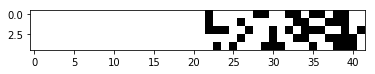

Predicted


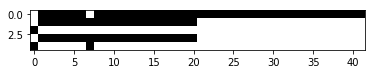

L
Autograd ArrayBox with value [[ 0.          0.10747532  0.08252887  0.06589028  0.05573271  0.04986512
   0.04658447  0.04478222  0.04379756  0.04325678]
 [ 0.10745416  0.          0.06993176  0.05759935  0.04968072  0.04496384
   0.04227968  0.04079066  0.03997281  0.03952231]
 [ 0.08250116  0.06992251  0.          0.049553    0.04357606  0.03990424
   0.03777635  0.03658372  0.03592496  0.03556095]
 [ 0.06586394  0.05758859  0.04955044  0.          0.03844139  0.03555529
   0.03385635  0.03289554  0.03236218  0.03206664]
 [ 0.05571039  0.04967169  0.043574    0.03844149  0.          0.03236929
   0.03095528  0.03015029  0.02970175  0.0294527 ]
 [ 0.04984684  0.04495724  0.03990359  0.03555633  0.03237008  0.
   0.02905699  0.02834666  0.0279499   0.02772929]
 [ 0.04656935  0.0422752   0.03777707  0.03385837  0.03095692  0.02905778
   0.          0.0272573   0.02689029  0.02668606]
 [ 0.04476928  0.04078771  0.03658549  0.03289835  0.03015258  0.02834807
   0.0272579   0.          0

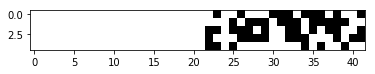

Predicted


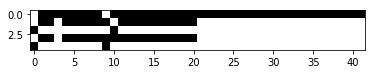

L
Autograd ArrayBox with value [[ 0.          0.10747684  0.08252915  0.06589005  0.05573242  0.04986494
   0.04658441  0.04478219  0.04379757  0.04325687]
 [ 0.10745526  0.          0.06993153  0.05759855  0.04967969  0.04496278
   0.04227865  0.04078962  0.03997177  0.03952131]
 [ 0.08250078  0.06992189  0.          0.04955149  0.04357432  0.03990242
   0.03777449  0.03658182  0.035923    0.03555898]
 [ 0.06586296  0.05758719  0.04954867  0.          0.03843937  0.03555323
   0.03385424  0.03289336  0.03235992  0.03206433]
 [ 0.05570937  0.04966997  0.04357188  0.03843932  0.          0.0323672
   0.03095316  0.03014808  0.02969945  0.02945033]
 [ 0.04984597  0.04495548  0.03990133  0.03555404  0.03236791  0.
   0.02905482  0.0283444   0.02794754  0.02772687]
 [ 0.04656864  0.04227347  0.03777475  0.03385599  0.03095464  0.02905555
   0.          0.02725493  0.02688783  0.02668353]
 [ 0.04476863  0.04078599  0.0365831   0.03289585  0.03015018  0.0283457
   0.02725549  0.          0.0

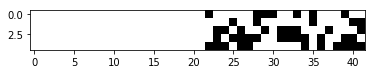

Predicted


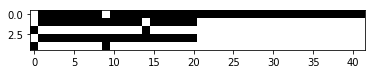

L
Autograd ArrayBox with value [[ 0.          0.10747439  0.08252931  0.0658911   0.05573338  0.04986547
   0.0465845   0.04478198  0.04379717  0.04325632]
 [ 0.10745343  0.          0.06993285  0.05760045  0.04968156  0.04496434
   0.04227987  0.04079061  0.0399726   0.03952203]
 [ 0.08250178  0.0699236   0.          0.04955418  0.04357711  0.03990512
   0.03777706  0.03658429  0.03592542  0.03556136]
 [ 0.06586481  0.05758963  0.04955161  0.          0.03844274  0.03555666
   0.03385767  0.0328968   0.03236338  0.03206781]
 [ 0.05571097  0.04967241  0.04357505  0.03844287  0.          0.03237105
   0.03095709  0.03015207  0.0297035   0.02945444]
 [ 0.04984699  0.04495758  0.03990448  0.03555775  0.03237188  0.
   0.02905908  0.02834876  0.02795198  0.02773137]
 [ 0.0465691   0.04227519  0.0377778   0.03385976  0.03095877  0.02905989
   0.          0.02725954  0.02689253  0.0266883 ]
 [ 0.04476872  0.04078744  0.03658606  0.03289968  0.03015443  0.02835019
   0.02726015  0.          0

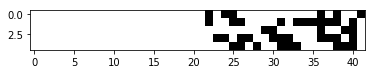

Predicted


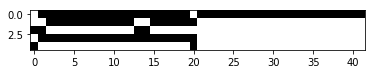

L
Autograd ArrayBox with value [[ 0.          0.1074695   0.08252943  0.06589313  0.05573551  0.04986705
   0.04658547  0.04478248  0.04379732  0.04325619]
 [ 0.10744894  0.          0.0699352   0.05760346  0.04968381  0.04496548
   0.04228004  0.0407901   0.03997164  0.03952075]
 [ 0.08250227  0.06992582  0.          0.04955725  0.04357872  0.03990515
   0.03777585  0.03658224  0.03592284  0.03555843]
 [ 0.06586702  0.05759214  0.04955424  0.          0.03844282  0.03555512
   0.03385488  0.03289318  0.03235924  0.03206334]
 [ 0.05571309  0.04967381  0.04357579  0.03844251  0.          0.03236774
   0.03095267  0.03014691  0.02969788  0.02944852]
 [ 0.0498484   0.04495761  0.03990334  0.03555546  0.03236826  0.
   0.02905324  0.02834227  0.02794509  0.02772422]
 [ 0.0465698   0.04227409  0.03777522  0.03385604  0.03095386  0.02905386
   0.          0.02725208  0.0268847   0.02668024]
 [ 0.04476888  0.04078556  0.03658254  0.03289501  0.03014866  0.02834341
   0.02725258  0.          0

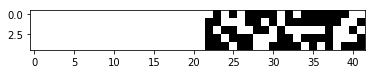

Predicted


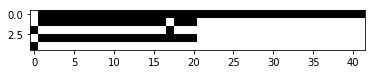

L
Autograd ArrayBox with value [[ 0.          0.107503    0.08253177  0.06588257  0.05572334  0.04985782
   0.04658001  0.04478018  0.04379734  0.04325792]
 [ 0.10747719  0.          0.06992556  0.05758601  0.0496662   0.04495112
   0.04226945  0.04078258  0.03996634  0.03951703]
 [ 0.08249762  0.06991371  0.          0.04953402  0.04355684  0.03988675
   0.03776103  0.03657024  0.03591282  0.03554978]
 [ 0.06584969  0.05757168  0.04953021  0.          0.03841995  0.03553557
   0.03383853  0.03287928  0.03234703  0.03205227]
 [ 0.05569505  0.04965351  0.04355312  0.03841953  0.          0.03234956
   0.03093721  0.03013353  0.02968592  0.02943751]
 [ 0.04983424  0.04494108  0.0398844   0.03553592  0.03235015  0.
   0.02903978  0.02833058  0.02793462  0.02771456]
 [ 0.04656015  0.0422618   0.03776012  0.03383984  0.03093856  0.02904049
   0.          0.0272422   0.0268759   0.02667216]
 [ 0.04476287  0.04077667  0.03657045  0.03288137  0.03013551  0.02833186
   0.02724276  0.          0

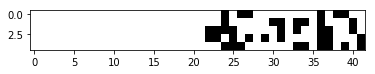

Predicted


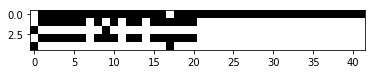

L
Autograd ArrayBox with value [[ 0.          0.10746217  0.08252871  0.06589521  0.05573802  0.04986898
   0.04658663  0.04478296  0.04379731  0.04325585]
 [ 0.1074429   0.          0.06993674  0.05760686  0.04968761  0.0449689
   0.04228289  0.04079242  0.03997357  0.03952241]
 [ 0.0825033   0.06992805  0.          0.04956201  0.04358378  0.03991001
   0.03778033  0.03658635  0.03592667  0.03556207]
 [ 0.06587087  0.05759653  0.0495594   0.          0.03844875  0.03556091
   0.0338604   0.03289844  0.03236429  0.03206825]
 [ 0.0557172   0.04967868  0.04358145  0.03844867  0.          0.03237394
   0.03095866  0.03015269  0.02970349  0.02945402]
 [ 0.04985177  0.04496211  0.03990889  0.03556161  0.0323746   0.
   0.02905933  0.02834818  0.02795086  0.0277299 ]
 [ 0.04657225  0.04227798  0.03778043  0.03386198  0.03096005  0.02906003
   0.          0.02725795  0.02689045  0.0266859 ]
 [ 0.04477055  0.04078889  0.03658739  0.03290072  0.03015468  0.02834944
   0.02725849  0.          0.

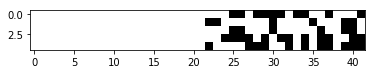

Predicted


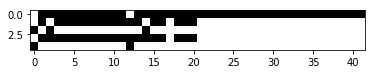

L
Autograd ArrayBox with value [[ 0.          0.10747336  0.08252871  0.06589094  0.05573352  0.04986575
   0.04658484  0.04478231  0.04379742  0.04325647]
 [ 0.10745251  0.          0.06993253  0.05760065  0.049682    0.04496483
   0.04228031  0.04079095  0.03997284  0.03952215]
 [ 0.08250142  0.06992345  0.          0.04955502  0.04357801  0.03990586
   0.03777757  0.03658458  0.03592554  0.03556133]
 [ 0.06586499  0.05759007  0.0495525   0.          0.03844383  0.03555746
   0.03385814  0.032897    0.03236336  0.03206763]
 [ 0.05571149  0.04967308  0.04357595  0.0384439   0.          0.03237161
   0.0309573   0.030152    0.02970321  0.02945398]
 [ 0.04984767  0.04495825  0.03990513  0.0355584   0.03237235  0.
   0.02905888  0.02834828  0.0279513   0.02773053]
 [ 0.04656984  0.04227577  0.03777815  0.03386001  0.03095882  0.02905962
   0.          0.02725867  0.02689146  0.02668708]
 [ 0.04476944  0.04078789  0.03658616  0.03289959  0.03015412  0.02834958
   0.02725923  0.          0

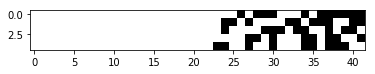

Predicted


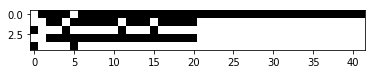

L
Autograd ArrayBox with value [[ 0.          0.10748176  0.08252985  0.06588882  0.05573076  0.04986353
   0.04658346  0.0447817   0.0437974   0.04325686]
 [ 0.10745942  0.          0.06993102  0.05759682  0.04967758  0.04496078
   0.04227694  0.04078825  0.03997065  0.03952031]
 [ 0.08250047  0.06992105  0.          0.04954924  0.04357177  0.03989986
   0.03777209  0.03657963  0.03592101  0.0355571 ]
 [ 0.0658607   0.05758497  0.04954622  0.          0.03843621  0.03555
   0.03385109  0.03289038  0.03235709  0.03206161]
 [ 0.05570672  0.0496673   0.043569    0.03843601  0.          0.03236343
   0.03094945  0.03014451  0.02969602  0.02944701]
 [ 0.04984364  0.04495288  0.03989835  0.03555057  0.03236406  0.
   0.02905086  0.02834057  0.02794385  0.02772327]
 [ 0.04656683  0.04227115  0.03777189  0.03385256  0.0309508   0.02905155
   0.          0.02725108  0.0268841   0.0266799 ]
 [ 0.04476733  0.04078399  0.03658044  0.03289258  0.03014646  0.02834181
   0.02725162  0.          0.02

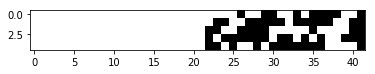

Predicted


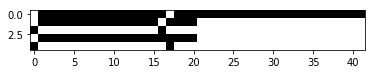

L
Autograd ArrayBox with value [[ 0.          0.10750475  0.08253156  0.0658816   0.05572235  0.04985708
   0.04657958  0.04478005  0.0437975   0.0432583 ]
 [ 0.10747881  0.          0.06992441  0.05758454  0.04966498  0.04495036
   0.04226915  0.04078268  0.03996678  0.03951771]
 [ 0.08249731  0.06991258  0.          0.049532    0.04355515  0.03988562
   0.03776046  0.03657013  0.03591308  0.0355503 ]
 [ 0.06584874  0.05757035  0.04952828  0.          0.03841803  0.0355342
   0.03383772  0.03287894  0.03234706  0.03205257]
 [ 0.0556942   0.04965256  0.04355166  0.03841774  0.          0.03234842
   0.03093659  0.03013335  0.02968609  0.02943793]
 [ 0.04983374  0.04494071  0.03988363  0.03553482  0.03234914  0.
   0.02903965  0.02833087  0.02793522  0.0277154 ]
 [ 0.04656002  0.04226198  0.03776001  0.0338394   0.03093818  0.02904047
   0.          0.027243    0.02687699  0.02667347]
 [ 0.04476311  0.04077731  0.03657088  0.03288149  0.03013566  0.02833233
   0.02724363  0.          0.

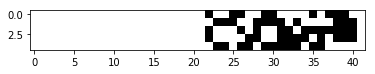

Predicted


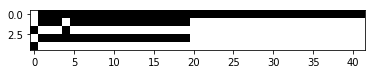

L
Autograd ArrayBox with value [[ 0.          0.10749443  0.08253011  0.06588411  0.05572565  0.0498598
   0.04658139  0.04478103  0.04379781  0.0432581 ]
 [ 0.10747028  0.          0.06992562  0.05758878  0.04967027  0.04495554
   0.04227379  0.04078674  0.03997034  0.03952088]
 [ 0.0824984   0.06991495  0.          0.04953866  0.04356272  0.03989322
   0.03776771  0.03657697  0.03591955  0.03555647]
 [ 0.06585395  0.05757637  0.0495357   0.          0.03842724  0.03554334
   0.03384654  0.03288741  0.03235522  0.03206048]
 [ 0.05570011  0.04965989  0.04356036  0.03842736  0.          0.03235817
   0.03094601  0.03014245  0.02969492  0.02944656]
 [ 0.04983891  0.044948    0.03989252  0.03554456  0.0323591   0.
   0.02904911  0.02834002  0.02794414  0.02772413]
 [ 0.04656414  0.04226872  0.03776862  0.03384891  0.03094791  0.02905002
   0.          0.02725199  0.02688577  0.02668208]
 [ 0.04476629  0.04078347  0.0365791   0.03289068  0.03014511  0.02834164
   0.02725268  0.          0.

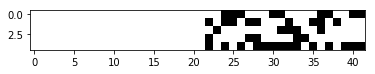

Predicted


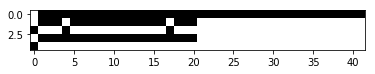

L
Autograd ArrayBox with value [[ 0.          0.10746932  0.0825302   0.06589395  0.05573604  0.04986728
   0.04658549  0.04478239  0.04379722  0.04325612]
 [ 0.10744862  0.          0.06993622  0.05760394  0.04968367  0.04496489
   0.0422792   0.04078914  0.03997067  0.03951982]
 [ 0.08250263  0.06992644  0.          0.04955664  0.04357735  0.03990332
   0.03777379  0.03658009  0.03592068  0.03555631]
 [ 0.06586723  0.05759191  0.04955328  0.          0.0384403   0.03555221
   0.0338518   0.03289005  0.03235612  0.03206026]
 [ 0.05571291  0.04967281  0.04357391  0.03843981  0.          0.03236415
   0.03094896  0.03014318  0.02969418  0.02944486]
 [ 0.04984788  0.04495612  0.03990093  0.0355523   0.0323646   0.
   0.02904925  0.02833827  0.02794112  0.0277203 ]
 [ 0.04656905  0.04227235  0.03777257  0.03385269  0.03095006  0.02904985
   0.          0.027248    0.02688065  0.02667623]
 [ 0.04476801  0.04078371  0.03657981  0.03289161  0.03014483  0.02833939
   0.02724849  0.          0

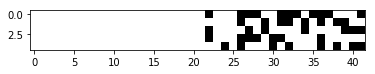

Predicted


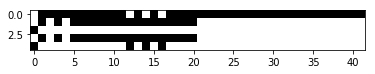

L
Autograd ArrayBox with value [[ 0.          0.10746     0.08252868  0.06589607  0.05573896  0.04986969
   0.04658706  0.04478314  0.04379727  0.04325562]
 [ 0.10744095  0.          0.06993786  0.05760838  0.04968885  0.04496964
   0.04228315  0.0407923   0.03997316  0.03952178]
 [ 0.08250354  0.0699292   0.          0.04956401  0.04358525  0.03991078
   0.03778048  0.03658603  0.03592602  0.03556117]
 [ 0.06587191  0.05759797  0.04956126  0.          0.03845002  0.03556146
   0.03386033  0.03289789  0.03236341  0.03206714]
 [ 0.05571822  0.04967968  0.04358262  0.03844976  0.          0.03237394
   0.03095808  0.03015169  0.02970219  0.02945251]
 [ 0.04985246  0.04496245  0.03990919  0.03556183  0.03237444  0.
   0.02905814  0.02834661  0.02794902  0.02772787]
 [ 0.04657258  0.04227773  0.03777999  0.03386146  0.03095922  0.02905873
   0.          0.02725586  0.02688811  0.02668339]
 [ 0.04477058  0.0407882   0.03658641  0.03289965  0.03015334  0.02834769
   0.02725633  0.          0

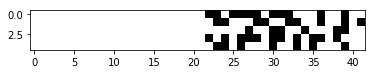

Predicted


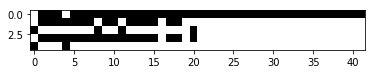

L
Autograd ArrayBox with value [[ 0.          0.10745686  0.08252893  0.06589752  0.05574043  0.04987076
   0.04658764  0.04478333  0.04379723  0.04325549]
 [ 0.10743823  0.          0.06993877  0.05760979  0.04969025  0.04497084
   0.04228411  0.04079304  0.03997377  0.03952236]
 [ 0.08250418  0.06993014  0.          0.04956513  0.04358642  0.03991196
   0.03778163  0.03658713  0.03592708  0.03556224]
 [ 0.06587365  0.05759941  0.04956243  0.          0.03845121  0.03556276
   0.03386169  0.03289927  0.03236479  0.03206854]
 [ 0.0557199   0.04968117  0.04358393  0.03845106  0.          0.03237549
   0.03095972  0.03015336  0.02970388  0.02945421]
 [ 0.04985367  0.04496381  0.03991063  0.03556334  0.03237609  0.
   0.02906002  0.02834853  0.02795095  0.02772981]
 [ 0.04657328  0.04227891  0.03778149  0.03386311  0.03096103  0.02906068
   0.          0.02725793  0.02689019  0.02668548]
 [ 0.04477085  0.04078919  0.03658791  0.03290137  0.03015524  0.02834972
   0.02725844  0.          0

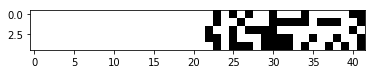

Predicted


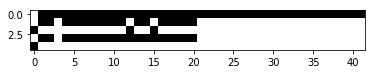

L
Autograd ArrayBox with value [[ 0.          0.10747593  0.0825304   0.06589163  0.05573352  0.04986543
   0.04658444  0.04478195  0.04379719  0.0432564 ]
 [ 0.10745425  0.          0.06993405  0.05760042  0.04968031  0.04496229
   0.04227741  0.04078794  0.03996986  0.03951926]
 [ 0.08250159  0.06992391  0.          0.04955244  0.04357371  0.03990053
   0.03777176  0.0365786   0.03591953  0.03555537]
 [ 0.06586377  0.05758802  0.04954904  0.          0.03843707  0.03554978
   0.03385004  0.03288875  0.03235509  0.0320594 ]
 [ 0.05570944  0.04966918  0.04357029  0.03843662  0.          0.03236234
   0.0309477   0.03014228  0.02969349  0.0294443 ]
 [ 0.04984527  0.04495336  0.03989822  0.03554996  0.03236282  0.
   0.02904846  0.02833778  0.0279408   0.02772007]
 [ 0.04656738  0.04227047  0.03777067  0.03385104  0.03094884  0.02904907
   0.          0.02724782  0.02688062  0.02667628]
 [ 0.04476704  0.04078248  0.03657848  0.03289042  0.03014398  0.02833891
   0.02724832  0.          0

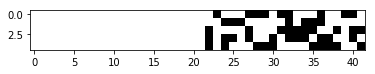

Predicted


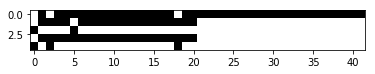

L
Autograd ArrayBox with value [[ 0.          0.10747883  0.08252874  0.06588878  0.05573119  0.04986406
   0.04658393  0.04478207  0.04379773  0.0432572 ]
 [ 0.1074572   0.          0.06992992  0.05759689  0.04967863  0.04496246
   0.04227897  0.04079044  0.03997294  0.03952271]
 [ 0.08250046  0.06992054  0.          0.04954992  0.0435736   0.0399026
   0.03777543  0.03658333  0.03592492  0.03556116]
 [ 0.065862    0.05758609  0.04954743  0.          0.03843916  0.03555385
   0.03385558  0.03289525  0.03236221  0.03206689]
 [ 0.05570861  0.04966974  0.04357177  0.03843939  0.          0.03236843
   0.03095501  0.03015043  0.02970216  0.02945329]
 [ 0.04984568  0.04495616  0.03990231  0.03555514  0.03236934  0.
   0.02905731  0.02834733  0.02795081  0.02773036]
 [ 0.04656882  0.04227489  0.03777662  0.03385794  0.03095684  0.02905818
   0.          0.02725843  0.02689163  0.02668754]
 [ 0.04476923  0.04078798  0.03658563  0.03289845  0.03015296  0.02834886
   0.02725908  0.          0.

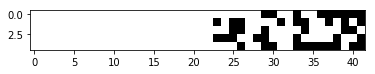

Predicted


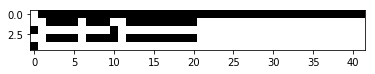

L
Autograd ArrayBox with value [[ 0.          0.10747264  0.08252941  0.06589196  0.05573431  0.04986621
   0.04658501  0.04478227  0.04379721  0.04325611]
 [ 0.10745164  0.          0.06993436  0.05760215  0.0496826   0.04496454
   0.04227934  0.04078953  0.03997111  0.0395202 ]
 [ 0.08250174  0.06992491  0.          0.04955635  0.04357809  0.03990472
   0.03777553  0.03658193  0.03592249  0.03555802]
 [ 0.0658654   0.05759079  0.04955335  0.          0.03844285  0.0355553
   0.03385509  0.03289334  0.03235931  0.03206333]
 [ 0.05571151  0.04967256  0.04357515  0.0384425   0.          0.03236825
   0.03095316  0.03014733  0.02969819  0.02944874]
 [ 0.04984722  0.04495659  0.03990284  0.03555555  0.03236871  0.
   0.02905375  0.02834269  0.0279454   0.02772444]
 [ 0.04656903  0.04227328  0.03777476  0.03385608  0.03095421  0.0290543
   0.          0.02725237  0.02688489  0.02668034]
 [ 0.04476837  0.04078485  0.03658205  0.03289495  0.03014888  0.02834371
   0.02725282  0.          0.0

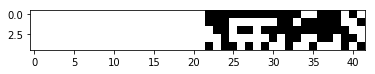

Predicted


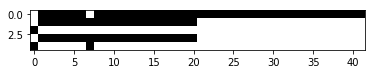

L
Autograd ArrayBox with value [[ 0.          0.10749922  0.08253083  0.06588303  0.05572419  0.04985859
   0.04658055  0.04478051  0.04379751  0.04325797]
 [ 0.10747429  0.          0.06992514  0.05758702  0.04966814  0.04495351
   0.04227201  0.04078519  0.03996894  0.03951959]
 [ 0.08249804  0.06991404  0.          0.04953623  0.04356014  0.03989079
   0.03776548  0.03657491  0.0359176   0.03555461]
 [ 0.0658517   0.05757398  0.04953304  0.          0.03842454  0.03554083
   0.03384422  0.03288523  0.03235313  0.03205846]
 [ 0.05569751  0.04965705  0.04355747  0.03842456  0.          0.03235575
   0.03094376  0.03014032  0.02969286  0.02944453]
 [ 0.0498366   0.04494524  0.03988971  0.03554189  0.03235662  0.
   0.02904695  0.02833796  0.02794213  0.02772216]
 [ 0.04656226  0.0422662   0.03776599  0.03384639  0.03094556  0.02904783
   0.          0.02724999  0.02688381  0.02668015]
 [ 0.04476475  0.04078117  0.03657662  0.03288828  0.03014285  0.02833951
   0.02725065  0.          0

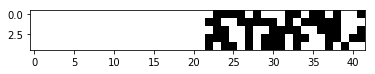

Predicted


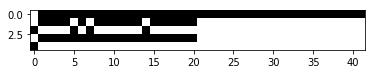

L
Autograd ArrayBox with value [[ 0.          0.10749397  0.08252998  0.0658842   0.05572584  0.04986001
   0.04658157  0.04478115  0.04379787  0.04325815]
 [ 0.10746979  0.          0.06992574  0.05758893  0.04967032  0.04495544
   0.04227356  0.04078639  0.03996989  0.03952038]
 [ 0.08249822  0.06991498  0.          0.0495387   0.04356252  0.03989278
   0.03776706  0.03657614  0.03591859  0.03555544]
 [ 0.06585397  0.05757632  0.0495356   0.          0.03842682  0.03554267
   0.03384564  0.03288631  0.03235398  0.03205915]
 [ 0.05570021  0.04965965  0.04355993  0.03842683  0.          0.03235726
   0.03094487  0.03014112  0.02969344  0.02944498]
 [ 0.04983902  0.04494757  0.03989178  0.0355437   0.0323581   0.
   0.02904769  0.02833842  0.02794239  0.02772228]
 [ 0.04656421  0.04226813  0.03776762  0.03384776  0.03094663  0.02904855
   0.          0.02725012  0.02688376  0.02667997]
 [ 0.04476629  0.04078273  0.03657789  0.0328893   0.03014359  0.02833993
   0.02725077  0.          0

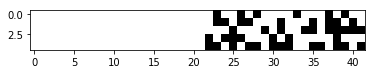

Predicted


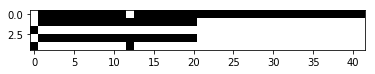

L
Autograd ArrayBox with value [[ 0.          0.10747742  0.08252929  0.06588996  0.05573225  0.04986477
   0.04658427  0.04478211  0.04379751  0.04325678]
 [ 0.10745576  0.          0.06993173  0.05759863  0.04967963  0.04496262
   0.04227842  0.04078938  0.0399715   0.03952099]
 [ 0.08250082  0.06992208  0.          0.04955176  0.0435744   0.03990228
   0.0377742   0.03658144  0.03592257  0.03555849]
 [ 0.06586277  0.05758723  0.04954889  0.          0.03843931  0.03555292
   0.03385374  0.03289276  0.03235925  0.03206362]
 [ 0.05570907  0.04966981  0.04357183  0.03843918  0.          0.03236658
   0.03095236  0.03014718  0.0296985   0.02944935]
 [ 0.04984565  0.04495516  0.03990099  0.03555358  0.03236722  0.
   0.02905375  0.02834325  0.02794635  0.02772565]
 [ 0.04656835  0.04227304  0.03777421  0.0338553   0.03095374  0.02905444
   0.          0.02725362  0.02688648  0.02668215]
 [ 0.04476839  0.04078551  0.03658244  0.03289503  0.03014915  0.02834448
   0.02725415  0.          0

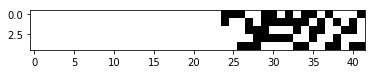

Predicted


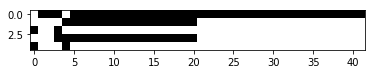

L
Autograd ArrayBox with value [[ 0.          0.10747696  0.08253006  0.06589087  0.05573284  0.049865
   0.04658426  0.04478198  0.04379735  0.04325659]
 [ 0.10745522  0.          0.06993313  0.05759961  0.04967989  0.04496226
   0.04227768  0.04078844  0.0399705   0.03951996]
 [ 0.0825013   0.06992318  0.          0.04955203  0.04357373  0.03990091
   0.03777241  0.03657944  0.03592051  0.03555641]
 [ 0.0658632   0.05758759  0.04954882  0.          0.0384374   0.03555036
   0.03385081  0.03288967  0.03235612  0.03206049]
 [ 0.05570905  0.04966926  0.04357061  0.03843705  0.          0.03236304
   0.03094852  0.03014323  0.02969453  0.02944539]
 [ 0.0498452   0.04495389  0.03989895  0.03555069  0.03236357  0.
   0.02904937  0.02833879  0.02794188  0.0277212 ]
 [ 0.0465676   0.04227133  0.03777169  0.03385199  0.03094975  0.02905001
   0.          0.02724892  0.02688178  0.02667749]
 [ 0.04476751  0.04078359  0.03657971  0.03289155  0.03014503  0.02833996
   0.02724943  0.          0.0

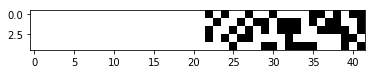

Predicted


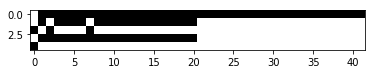

L
Autograd ArrayBox with value [[ 0.          0.10747983  0.08252943  0.06588919  0.05573139  0.04986413
   0.04658391  0.04478196  0.04379749  0.04325685]
 [ 0.10745777  0.          0.06993112  0.05759749  0.04967845  0.04496161
   0.04227763  0.04078875  0.03997098  0.03952054]
 [ 0.08250044  0.0699213   0.          0.04955036  0.04357303  0.03990106
   0.03777313  0.03658048  0.03592169  0.03555765]
 [ 0.0658615   0.05758586  0.04954741  0.          0.0384379   0.03555164
   0.03385257  0.03289166  0.0323582   0.03206259]
 [ 0.05570776  0.04966839  0.04357035  0.03843773  0.          0.0323653
   0.03095116  0.03014604  0.02969738  0.02944824]
 [ 0.04984462  0.04495392  0.03989964  0.03555222  0.03236591  0.
   0.02905256  0.02834209  0.02794521  0.02772451]
 [ 0.04656764  0.04227202  0.03777299  0.03385403  0.03095248  0.02905322
   0.          0.02725245  0.02688532  0.026681  ]
 [ 0.04476792  0.04078466  0.03658134  0.03289382  0.03014793  0.02834328
   0.02725296  0.          0.

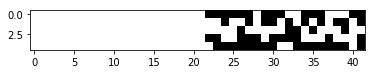

Predicted


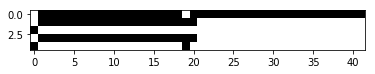

L
Autograd ArrayBox with value [[ 0.          0.10749868  0.08253179  0.06588422  0.05572506  0.04985903
   0.04658065  0.04478038  0.04379725  0.04325762]
 [ 0.10747354  0.          0.06992726  0.05758853  0.0496685   0.04495284
   0.0422706   0.04078331  0.03996679  0.03951728]
 [ 0.08249845  0.06991563  0.          0.04953701  0.0435594   0.03988871
   0.03776247  0.03657131  0.03591366  0.03555045]
 [ 0.06585206  0.05757441  0.04953322  0.          0.03842226  0.03553732
   0.03383983  0.03288027  0.03234784  0.03205296]
 [ 0.05569731  0.04965594  0.04355566  0.03842181  0.          0.03235086
   0.03093813  0.03013421  0.02968646  0.02943796]
 [ 0.04983585  0.04494284  0.03988629  0.03553762  0.03235144  0.
   0.02904033  0.02833093  0.02793485  0.02771473]
 [ 0.04656108  0.04226292  0.03776145  0.03384106  0.03093946  0.02904103
   0.          0.02724231  0.02687591  0.02667211]
 [ 0.04476331  0.04077734  0.03657139  0.03288229  0.03013617  0.02833221
   0.02724287  0.          0

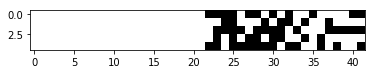

Predicted


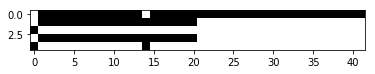

L
Autograd ArrayBox with value [[ 0.          0.10748864  0.08252979  0.06588601  0.05572778  0.04986137
   0.04658226  0.04478132  0.04379772  0.04325779]
 [ 0.10746543  0.          0.06992739  0.05759172  0.04967314  0.04495781
   0.04227541  0.04078784  0.03997109  0.03952143]
 [ 0.0824993   0.06991708  0.          0.04954214  0.0435659   0.03989589
   0.03776986  0.03657871  0.03592103  0.0355578 ]
 [ 0.06585699  0.05757969  0.04953926  0.          0.03843042  0.0355461
   0.03384891  0.03288948  0.03235709  0.03206224]
 [ 0.05570319  0.04966308  0.04356366  0.03843058  0.          0.03236083
   0.03094837  0.03014457  0.02969688  0.02944843]
 [ 0.04984125  0.04495052  0.03989529  0.03554739  0.03236179  0.
   0.02905133  0.02834204  0.02794603  0.02772594]
 [ 0.04656565  0.04227053  0.03777087  0.03385137  0.03095032  0.02905226
   0.          0.02725386  0.02688753  0.02668377]
 [ 0.04476712  0.04078472  0.03658094  0.03289285  0.0301473   0.0283437
   0.02725457  0.          0.0

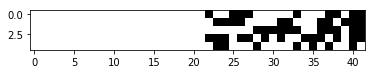

Predicted


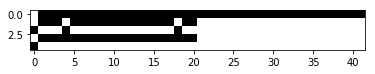

L
Autograd ArrayBox with value [[ 0.          0.10748592  0.0825294   0.06588677  0.05572879  0.04986221
   0.04658279  0.04478151  0.04379754  0.04325726]
 [ 0.10746314  0.          0.06992851  0.05759384  0.04967534  0.04495958
   0.04227663  0.04078854  0.03997133  0.03952127]
 [ 0.0824996   0.06991861  0.          0.0495461   0.04356979  0.03989913
   0.03777235  0.03658056  0.03592234  0.03555869]
 [ 0.06585846  0.05758235  0.04954338  0.          0.0384352   0.03555017
   0.03385217  0.03289205  0.03235913  0.03206388]
 [ 0.0557048   0.0496657   0.04356761  0.03843528  0.          0.03236472
   0.03095149  0.03014705  0.02969886  0.02945003]
 [ 0.04984255  0.04495252  0.03989842  0.03555122  0.03236553  0.
   0.02905377  0.02834388  0.02794741  0.02772698]
 [ 0.04656651  0.04227181  0.03777307  0.03385423  0.03095315  0.02905456
   0.          0.02725496  0.02688819  0.02668411]
 [ 0.04476756  0.04078535  0.03658237  0.03289491  0.03014936  0.02834529
   0.02725556  0.          0

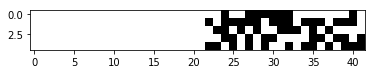

Predicted


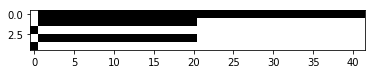

L
Autograd ArrayBox with value [[ 0.          0.1074937   0.08253131  0.06588569  0.05572685  0.04986046
   0.04658155  0.04478081  0.04379732  0.04325744]
 [ 0.10746929  0.          0.06992848  0.05759095  0.04967102  0.04495491
   0.04227212  0.04078435  0.03996748  0.03951773]
 [ 0.08249896  0.06991719  0.          0.04954028  0.04356248  0.03989127
   0.03776446  0.03657283  0.03591483  0.0355514 ]
 [ 0.06585451  0.05757725  0.04953657  0.          0.03842553  0.03554008
   0.03384206  0.03288208  0.03234933  0.03205425]
 [ 0.05569998  0.04965881  0.04355881  0.03842507  0.          0.03235347
   0.03094029  0.030136    0.02968797  0.02943929]
 [ 0.04983803  0.04494519  0.03988885  0.03554032  0.03235401  0.
   0.02904219  0.02833247  0.02793615  0.02771586]
 [ 0.04656263  0.04226465  0.03776339  0.03384319  0.03094154  0.02904286
   0.          0.02724353  0.02687691  0.02667296]
 [ 0.04476432  0.04077853  0.03657283  0.03288396  0.03013784  0.02833368
   0.02724406  0.          0

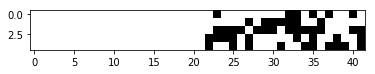

Predicted


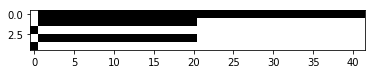

L
Autograd ArrayBox with value [[ 0.          0.10748129  0.08252906  0.06588814  0.05573034  0.04986334
   0.04658343  0.04478179  0.04379762  0.04325725]
 [ 0.10745929  0.          0.06992954  0.0575958   0.04967735  0.04496129
   0.04227799  0.04078965  0.03997232  0.03952222]
 [ 0.08250028  0.06991993  0.          0.04954824  0.04357185  0.03990101
   0.03777407  0.03658216  0.03592392  0.03556029]
 [ 0.06586083  0.05758468  0.04954564  0.          0.0384372   0.03555212
   0.0338541   0.03289399  0.03236111  0.03206592]
 [ 0.05570726  0.04966811  0.04356988  0.03843741  0.          0.03236684
   0.03095368  0.03014932  0.02970121  0.02945246]
 [ 0.0498445   0.04495465  0.0399006   0.0355534   0.03236776  0.
   0.02905625  0.02834649  0.02795012  0.02772978]
 [ 0.0465679   0.04227361  0.03777515  0.03385647  0.03095554  0.02905714
   0.          0.02725785  0.0268912   0.02668722]
 [ 0.04476854  0.04078691  0.03658438  0.03289722  0.0301519   0.02834806
   0.02725852  0.          0

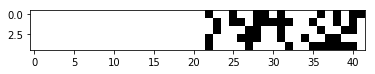

Predicted


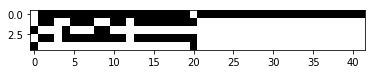

L
Autograd ArrayBox with value [[ 0.          0.10747025  0.08252951  0.06589292  0.05573525  0.04986685
   0.04658537  0.04478246  0.04379735  0.04325625]
 [ 0.10744956  0.          0.06993498  0.05760306  0.04968339  0.04496513
   0.04227979  0.04078992  0.03997153  0.03952067]
 [ 0.08250217  0.06992553  0.          0.04955668  0.04357813  0.03990462
   0.03777538  0.03658183  0.03592247  0.03555809]
 [ 0.06586663  0.05759165  0.04955363  0.          0.0384421   0.0355544
   0.03385421  0.03289254  0.03235863  0.03206275]
 [ 0.05571267  0.04967331  0.04357516  0.03844176  0.          0.03236691
   0.03095185  0.03014612  0.02969711  0.02944777]
 [ 0.04984807  0.04495719  0.03990275  0.03555472  0.03236742  0.
   0.02905236  0.0283414   0.02794424  0.02772338]
 [ 0.04656959  0.04227378  0.0377747   0.03385533  0.03095302  0.02905297
   0.          0.02725118  0.02688382  0.02667937]
 [ 0.04476876  0.04078533  0.03658208  0.03289434  0.03014785  0.02834253
   0.02725168  0.          0.

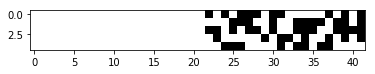

Predicted


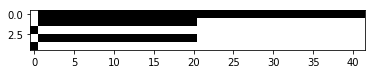

L
Autograd ArrayBox with value [[ 0.          0.10748298  0.08252955  0.06588804  0.05573008  0.04986312
   0.04658329  0.04478171  0.04379756  0.04325717]
 [ 0.10746052  0.          0.06992983  0.05759549  0.0496766   0.04496027
   0.04227683  0.04078841  0.039971    0.03952083]
 [ 0.08250004  0.06991985  0.          0.04954756  0.04357061  0.03989931
   0.03777203  0.0365799   0.03592149  0.03555774]
 [ 0.0658599   0.05758373  0.04954464  0.          0.0384354   0.03554982
   0.03385141  0.03289102  0.03235794  0.03206261]
 [ 0.05570613  0.04966655  0.04356808  0.03843535  0.          0.03236392
   0.03095039  0.03014574  0.02969744  0.02944855]
 [ 0.04984341  0.04495273  0.03989817  0.03555066  0.03236466  0.
   0.0290524   0.02834237  0.02794581  0.02772534]
 [ 0.04656691  0.04227148  0.03777229  0.03385322  0.03095193  0.02905316
   0.          0.0272533   0.02688647  0.02668236]
 [ 0.04476763  0.04078466  0.03658123  0.0328936   0.03014793  0.02834373
   0.02725388  0.          0

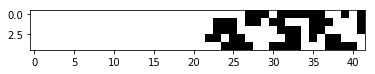

Predicted


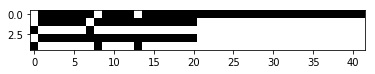

L
Autograd ArrayBox with value [[ 0.          0.10748708  0.08253062  0.06588752  0.05572907  0.04986218
   0.04658261  0.04478131  0.0437974   0.04325721]
 [ 0.10746381  0.          0.06992979  0.057594    0.04967445  0.04495803
   0.04227474  0.04078654  0.03996933  0.03951933]
 [ 0.08249985  0.06991916  0.          0.04954464  0.04356708  0.03989563
   0.03776846  0.0365765   0.03591826  0.03555464]
 [ 0.06585794  0.05758124  0.04954131  0.          0.03843077  0.03554507
   0.03384674  0.0328865   0.03235357  0.03205835]
 [ 0.05570369  0.04966326  0.04356394  0.03843049  0.          0.03235858
   0.03094512  0.03014061  0.02969243  0.02944364]
 [ 0.0498411   0.04494932  0.03989381  0.03554559  0.03235921  0.
   0.02904692  0.02833701  0.02794056  0.02772019]
 [ 0.04656492  0.04226825  0.03776801  0.03384821  0.03094653  0.02904765
   0.          0.02724794  0.02688121  0.02667718]
 [ 0.04476596  0.04078167  0.03657713  0.03288874  0.03014264  0.02833832
   0.0272485   0.          0

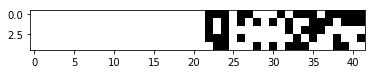

Predicted


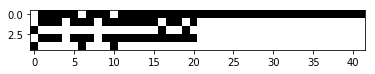

L
Autograd ArrayBox with value [[ 0.          0.10747261  0.08253038  0.06589294  0.05573495  0.04986649
   0.04658503  0.04478215  0.04379707  0.04325602]
 [ 0.10745138  0.          0.06993551  0.05760262  0.04968235  0.04496378
   0.04227831  0.04078837  0.03996993  0.03951907]
 [ 0.08250214  0.06992555  0.          0.04955546  0.04357638  0.03990254
   0.03777312  0.03657945  0.03592001  0.0355556 ]
 [ 0.06586556  0.05759038  0.04955205  0.          0.0384399   0.035552
   0.03385166  0.03288988  0.03235588  0.03205996]
 [ 0.05571121  0.04967126  0.04357285  0.03843936  0.          0.03236435
   0.03094919  0.03014336  0.02969427  0.02944487]
 [ 0.04984654  0.04495476  0.03990002  0.03555199  0.03236473  0.
   0.02904958  0.02833855  0.0279413   0.0277204 ]
 [ 0.04656808  0.04227118  0.03777173  0.03385238  0.03095016  0.02905012
   0.          0.02724821  0.02688077  0.02667627]
 [ 0.04476727  0.04078264  0.03657895  0.03289123  0.03014484  0.02833955
   0.02724866  0.          0.0

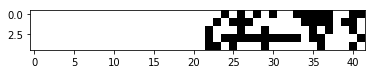

Predicted


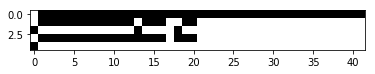

L
Autograd ArrayBox with value [[ 0.          0.10746687  0.08252941  0.0658941   0.05573654  0.04986778
   0.04658584  0.04478256  0.04379723  0.04325603]
 [ 0.1074468   0.          0.06993582  0.0576046   0.04968507  0.04496666
   0.04228108  0.040791    0.03997246  0.03952155]
 [ 0.08250284  0.06992662  0.          0.04955843  0.04358012  0.03990672
   0.03777749  0.0365839   0.03592452  0.03556014]
 [ 0.06586853  0.05759356  0.04955557  0.          0.03844452  0.03555707
   0.033857    0.0328954   0.03236151  0.03206567]
 [ 0.05571459  0.04967544  0.04357751  0.03844438  0.          0.03237012
   0.03095522  0.03014958  0.02970061  0.0294513 ]
 [ 0.04984953  0.04495922  0.03990534  0.03555771  0.03237077  0.
   0.02905615  0.02834528  0.02794816  0.02772734]
 [ 0.04657053  0.04227559  0.03777738  0.03385855  0.03095664  0.02905686
   0.          0.02725532  0.026888    0.02668358]
 [ 0.04476927  0.04078694  0.03658477  0.03289768  0.0301516   0.02834657
   0.02725588  0.          0

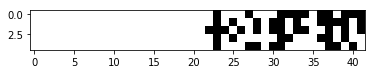

Predicted


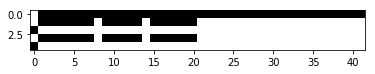

L
Autograd ArrayBox with value [[ 0.          0.10747804  0.08252981  0.06589028  0.05573238  0.04986475
   0.04658414  0.0447819   0.04379724  0.04325649]
 [ 0.10745622  0.          0.06993242  0.05759894  0.04967956  0.04496225
   0.04227785  0.04078866  0.03997069  0.03952015]
 [ 0.08250102  0.06992256  0.          0.04955184  0.04357416  0.03990179
   0.03777351  0.03658061  0.03592164  0.03555752]
 [ 0.06586264  0.05758716  0.04954881  0.          0.03843899  0.03555247
   0.03385316  0.03289206  0.03235848  0.0320628 ]
 [ 0.05570868  0.04966926  0.04357133  0.03843877  0.          0.03236617
   0.03095188  0.03014663  0.02969788  0.02944869]
 [ 0.04984506  0.04495425  0.03990018  0.03555298  0.03236676  0.
   0.0290533   0.02834275  0.0279458   0.02772506]
 [ 0.04656761  0.04227188  0.03777317  0.03385453  0.03095317  0.02905396
   0.          0.02725309  0.02688591  0.02668156]
 [ 0.04476755  0.04078418  0.03658123  0.03289413  0.03014848  0.02834392
   0.0272536   0.          0

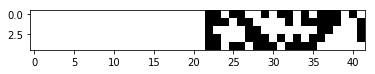

Predicted


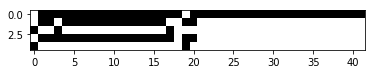

L
Autograd ArrayBox with value [[ 0.          0.10747828  0.08253048  0.06589073  0.05573251  0.04986467
   0.04658401  0.04478185  0.04379739  0.04325684]
 [ 0.10745627  0.          0.06993285  0.05759865  0.04967868  0.04496113
   0.04227674  0.0407877   0.03996998  0.03951967]
 [ 0.08250122  0.06992254  0.          0.04954972  0.04357124  0.03989861
   0.03777041  0.03657774  0.03591906  0.03555519]
 [ 0.06586249  0.0575861   0.04954631  0.          0.03843418  0.03554743
   0.03384827  0.03288746  0.03235418  0.03205876]
 [ 0.05570817  0.04966753  0.0435679   0.03843381  0.          0.03236019
   0.03094609  0.03014113  0.02969269  0.02944376]
 [ 0.04984438  0.04495231  0.03989651  0.03554781  0.03236078  0.
   0.02904737  0.02833711  0.02794046  0.02771997]
 [ 0.04656692  0.04227003  0.03776965  0.03384957  0.03094744  0.02904808
   0.          0.0272477   0.0268808   0.02667668]
 [ 0.04476698  0.04078255  0.03657802  0.03288951  0.03014311  0.02833841
   0.02724826  0.          0

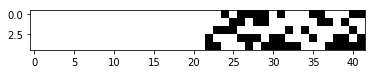

Predicted


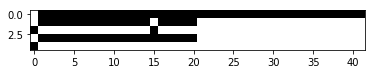

L
Autograd ArrayBox with value [[ 0.          0.10747669  0.08252944  0.06589036  0.05573256  0.04986491
   0.04658426  0.04478202  0.0437974   0.04325667]
 [ 0.10745517  0.          0.06993233  0.05759924  0.04968003  0.04496279
   0.04227843  0.0407893   0.03997141  0.03952091]
 [ 0.08250113  0.06992269  0.          0.0495522   0.04357457  0.03990227
   0.03777407  0.03658127  0.03592241  0.03555836]
 [ 0.06586328  0.05758778  0.04954928  0.          0.03843915  0.03555263
   0.0338534   0.03289242  0.03235895  0.03206337]
 [ 0.05570943  0.04967011  0.04357193  0.038439    0.          0.03236613
   0.03095191  0.03014677  0.02969813  0.02944903]
 [ 0.04984578  0.04495519  0.03990089  0.03555328  0.03236678  0.
   0.02905331  0.02834286  0.02794602  0.02772537]
 [ 0.04656829  0.04227289  0.037774    0.03385496  0.03095331  0.02905401
   0.          0.02725329  0.02688622  0.02668195]
 [ 0.04476823  0.04078527  0.03658219  0.03289471  0.03014877  0.02834412
   0.02725384  0.          0

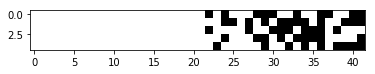

Predicted


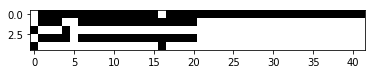

L
Autograd ArrayBox with value [[ 0.          0.10748754  0.08253089  0.06588764  0.05572906  0.04986207
   0.04658244  0.04478109  0.04379712  0.04325683]
 [ 0.10746423  0.          0.0699305   0.05759461  0.04967479  0.04495807
   0.04227454  0.04078616  0.03996882  0.03951869]
 [ 0.08250007  0.06991989  0.          0.04954576  0.04356793  0.03989612
   0.03776861  0.03657642  0.03591801  0.03555426]
 [ 0.06585796  0.05758181  0.04954238  0.          0.03843178  0.03554575
   0.03384711  0.03288664  0.03235354  0.0320582 ]
 [ 0.0557035   0.04966346  0.04356465  0.03843141  0.          0.03235913
   0.03094542  0.03014071  0.02969239  0.0294435 ]
 [ 0.04984073  0.0449491   0.03989405  0.03554609  0.03235968  0.          0.029047
   0.02833693  0.02794037  0.0277199 ]
 [ 0.04656443  0.04226769  0.03776783  0.03384832  0.03094667  0.02904766
   0.          0.02724765  0.02688082  0.02667672]
 [ 0.04476539  0.04078087  0.03657665  0.03288856  0.03014254  0.02833813
   0.02724817  0.     

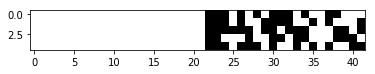

Predicted


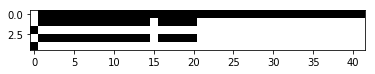

L
Autograd ArrayBox with value [[ 0.          0.10749859  0.08253071  0.0658831   0.0557243   0.04985866
   0.04658059  0.04478056  0.04379763  0.04325817]
 [ 0.10747379  0.          0.06992507  0.05758698  0.04966811  0.04495349
   0.04227203  0.04078527  0.03996912  0.03951988]
 [ 0.08249808  0.06991397  0.          0.04953572  0.04355953  0.0398902
   0.03776499  0.03657453  0.03591735  0.03555447]
 [ 0.06585196  0.05757393  0.0495325   0.          0.03842342  0.03553975
   0.03384326  0.03288441  0.03235245  0.03205789]
 [ 0.0556978   0.04965702  0.04355684  0.03842345  0.          0.0323545
   0.03094265  0.03013935  0.02969202  0.02944381]
 [ 0.04983687  0.04494526  0.03988916  0.03554086  0.03235542  0.
   0.02904594  0.02833709  0.02794138  0.02772151]
 [ 0.0465625   0.0422663   0.03776558  0.03384554  0.03094454  0.02904686
   0.          0.02724929  0.02688323  0.02667966]
 [ 0.04476502  0.04078135  0.03657636  0.03288761  0.03014201  0.02833872
   0.02724998  0.          0.0

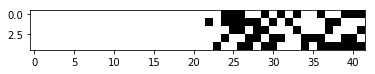

Predicted


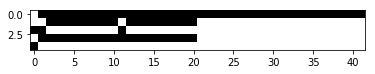

L
Autograd ArrayBox with value [[ 0.          0.10748381  0.08252968  0.06588783  0.05572976  0.04986283
   0.04658309  0.04478161  0.04379755  0.0432572 ]
 [ 0.10746123  0.          0.06992985  0.05759525  0.04967621  0.04495984
   0.04227642  0.04078805  0.03997071  0.03952058]
 [ 0.08250002  0.0699198   0.          0.04954713  0.04356995  0.03989852
   0.03777121  0.03657911  0.03592075  0.03555703]
 [ 0.06585953  0.05758337  0.04954413  0.          0.03843434  0.0355486
   0.03385014  0.03288976  0.03235673  0.03206142]
 [ 0.05570566  0.049666    0.04356728  0.03843421  0.          0.03236236
   0.03094878  0.03014415  0.02969589  0.02944704]
 [ 0.04984297  0.04495209  0.0398972   0.03554933  0.03236306  0.
   0.02905063  0.02834062  0.0279441   0.02772367]
 [ 0.04656656  0.04227085  0.03777126  0.03385182  0.03095027  0.02905137
   0.          0.02725151  0.02688472  0.02668065]
 [ 0.04476738  0.04078408  0.03658021  0.03289222  0.03014628  0.02834196
   0.02725209  0.          0.

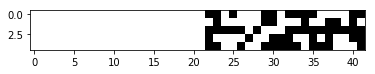

Predicted


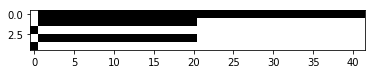

L
Autograd ArrayBox with value [[ 0.          0.10749759  0.08252931  0.06588217  0.05572395  0.04985874
   0.04658089  0.04478088  0.04379781  0.04325818]
 [ 0.10747319  0.          0.06992362  0.05758677  0.04966903  0.0449551
   0.04227393  0.0407872   0.03997092  0.0395215 ]
 [ 0.08249755  0.06991325  0.          0.04953772  0.04356291  0.03989431
   0.03776934  0.03657886  0.03592153  0.03555846]
 [ 0.0658522   0.05757499  0.04953513  0.          0.03842918  0.03554611
   0.03384976  0.03289082  0.03235867  0.03206392]
 [ 0.05569878  0.04965947  0.04356115  0.03842953  0.          0.03236219
   0.03095038  0.03014695  0.02969942  0.02945102]
 [ 0.04983832  0.04494845  0.03989427  0.03554764  0.03236321  0.
   0.02905409  0.02834508  0.02794918  0.02772912]
 [ 0.04656417  0.04226977  0.03777092  0.03385245  0.03095238  0.02905502
   0.          0.02725726  0.026891    0.02668725]
 [ 0.04476668  0.04078483  0.03658166  0.0328944   0.03014969  0.0283467
   0.02725793  0.          0.0

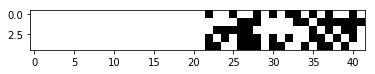

Predicted


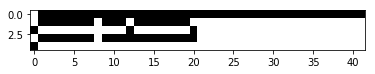

L
Autograd ArrayBox with value [[ 0.          0.10748838  0.08253126  0.06588765  0.0557289   0.04986187
   0.04658227  0.04478099  0.04379713  0.04325699]
 [ 0.10746487  0.          0.06993041  0.057594    0.04967398  0.04495729
   0.04227389  0.04078565  0.03996846  0.03951849]
 [ 0.08250007  0.06991952  0.          0.04954412  0.04356616  0.03989451
   0.03776725  0.03657529  0.03591708  0.03555351]
 [ 0.06585753  0.05758079  0.0495406   0.          0.03842946  0.03554368
   0.03384536  0.03288516  0.03235228  0.03205711]
 [ 0.05570291  0.04966225  0.04356274  0.0384291   0.          0.0323571
   0.0309437   0.03013926  0.02969115  0.02944242]
 [ 0.04984015  0.04494799  0.03989237  0.03554409  0.03235771  0.
   0.02904557  0.02833575  0.02793937  0.02771905]
 [ 0.04656392  0.04226678  0.03776648  0.03384671  0.03094508  0.02904629
   0.          0.02724678  0.02688013  0.02667616]
 [ 0.04476497  0.04078015  0.03657559  0.03288728  0.03014127  0.02833705
   0.02724735  0.          0.

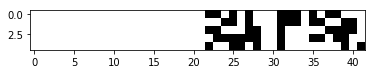

Predicted


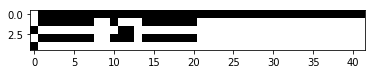

L
Autograd ArrayBox with value [[ 0.          0.10746598  0.08252885  0.06589393  0.05573665  0.04986802
   0.04658612  0.04478279  0.04379736  0.04325607]
 [ 0.10744608  0.          0.06993538  0.05760472  0.04968558  0.04496734
   0.0422818   0.04079165  0.03997301  0.039522  ]
 [ 0.08250261  0.06992642  0.          0.04955934  0.04358143  0.03990815
   0.03777889  0.03658519  0.03592567  0.03556117]
 [ 0.06586881  0.05759408  0.04955666  0.          0.03844661  0.03555922
   0.03385907  0.03289732  0.03236329  0.03206731]
 [ 0.05571518  0.04967641  0.04357905  0.03844653  0.          0.03237265
   0.03095765  0.03015185  0.02970273  0.0294533 ]
 [ 0.04985028  0.04496037  0.039907    0.03555992  0.0323733   0.
   0.02905861  0.0283476   0.02795033  0.02772939]
 [ 0.0465713   0.04227676  0.03777898  0.03386065  0.03095903  0.0290593
   0.          0.02725751  0.02689006  0.02668552]
 [ 0.04476999  0.04078804  0.03658624  0.0328996   0.03015381  0.02834882
   0.02725804  0.          0.

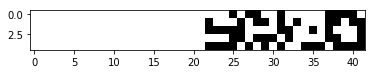

Predicted


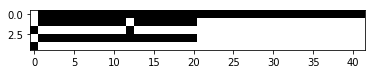

L
Autograd ArrayBox with value [[ 0.          0.10749414  0.08253106  0.06588525  0.05572643  0.04986012
   0.0465813   0.04478064  0.04379721  0.04325734]
 [ 0.10746988  0.          0.06992811  0.05759076  0.04967111  0.04495524
   0.04227262  0.04078497  0.03996817  0.03951845]
 [ 0.08249904  0.06991711  0.          0.04954063  0.04356331  0.03989247
   0.03776591  0.03657446  0.03591657  0.0355532 ]
 [ 0.06585448  0.05757754  0.04953719  0.          0.03842703  0.03554196
   0.03384422  0.03288443  0.03235181  0.0320568 ]
 [ 0.05570001  0.0496595   0.04356005  0.03842674  0.          0.03235588
   0.03094296  0.03013885  0.02969095  0.02944234]
 [ 0.04983813  0.04494615  0.03989055  0.03554248  0.03235653  0.
   0.02904525  0.0283357   0.0279395   0.02771928]
 [ 0.04656281  0.04226579  0.03776539  0.0338457   0.03094439  0.02904598
   0.          0.02724703  0.02688053  0.02667665]
 [ 0.04476456  0.04077979  0.03657502  0.03288668  0.03014091  0.02833702
   0.0272476   0.          0

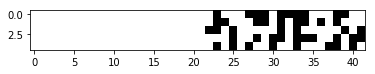

Predicted


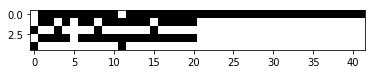

L
Autograd ArrayBox with value [[ 0.          0.10746155  0.08252791  0.06589469  0.05573787  0.04986913
   0.04658696  0.04478337  0.0437977   0.04325621]
 [ 0.10744234  0.          0.06993564  0.05760631  0.04968761  0.04496931
   0.04228353  0.04079315  0.03997431  0.03952312]
 [ 0.08250273  0.06992716  0.          0.04956192  0.04358416  0.03991067
   0.03778112  0.03658717  0.03592745  0.03556279]
 [ 0.06587074  0.05759636  0.04955946  0.          0.03844952  0.03556178
   0.03386126  0.03289924  0.032365    0.03206888]
 [ 0.05571757  0.04967918  0.04358207  0.03844949  0.          0.03237484
   0.03095945  0.03015337  0.02970405  0.02945448]
 [ 0.04985251  0.04496306  0.0399098   0.03556253  0.03237549  0.
   0.02905994  0.02834864  0.02795119  0.02773012]
 [ 0.04657322  0.0422792   0.03778147  0.03386288  0.03096081  0.02906061
   0.          0.02725817  0.02689053  0.02668587]
 [ 0.04477162  0.04079022  0.03658846  0.03290154  0.0301553   0.02834984
   0.02725869  0.          0

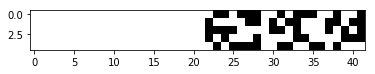

Predicted


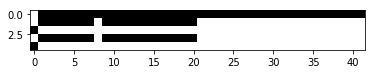

L
Autograd ArrayBox with value [[ 0.          0.10747858  0.08252976  0.06588995  0.05573201  0.04986447
   0.046584    0.04478192  0.04379745  0.04325685]
 [ 0.10745668  0.          0.06993186  0.05759815  0.04967882  0.04496171
   0.04227757  0.04078863  0.03997089  0.03952053]
 [ 0.08250088  0.06992193  0.          0.04955028  0.04357257  0.03990043
   0.03777246  0.03657985  0.03592115  0.03555723]
 [ 0.06586226  0.05758629  0.04954721  0.          0.03843668  0.03555033
   0.03385132  0.03289052  0.03235719  0.03206171]
 [ 0.05570832  0.04966849  0.04356975  0.03843649  0.          0.03236372
   0.03094969  0.0301447   0.02969619  0.02944717]
 [ 0.04984486  0.04495376  0.0398989   0.03555094  0.03236438  0.
   0.02905115  0.02834083  0.02794409  0.02772352]
 [ 0.0465676   0.04227173  0.03777227  0.03385286  0.03095111  0.02905187
   0.          0.02725138  0.02688439  0.02668018]
 [ 0.04476774  0.04078433  0.0365807   0.03289282  0.03014674  0.02834213
   0.02725194  0.          0

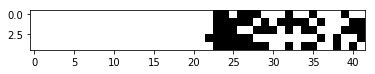

Predicted


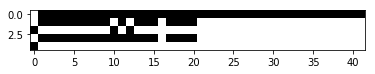

L
Autograd ArrayBox with value [[ 0.          0.1074878   0.08253034  0.06588699  0.05572865  0.04986197
   0.04658258  0.04478139  0.04379757  0.04325747]
 [ 0.1074644   0.          0.06992895  0.05759309  0.04967375  0.04495762
   0.04227458  0.04078653  0.03996943  0.03951953]
 [ 0.08249945  0.06991829  0.          0.04954339  0.04356606  0.03989491
   0.03776798  0.03657618  0.03591804  0.03555451]
 [ 0.06585736  0.05758032  0.04954006  0.          0.03842971  0.03554428
   0.03384616  0.03288605  0.03235319  0.03205802]
 [ 0.05570331  0.04966262  0.04356297  0.03842947  0.          0.03235792
   0.03094462  0.0301402   0.02969206  0.02944331]
 [ 0.04984099  0.04494904  0.03989319  0.03554486  0.03235858  0.
   0.02904654  0.02833669  0.02794027  0.02771991]
 [ 0.04656504  0.04226826  0.03776768  0.03384771  0.03094607  0.02904728
   0.          0.02724768  0.02688096  0.02667695]
 [ 0.04476622  0.04078187  0.03657698  0.03288838  0.03014228  0.02833801
   0.02724825  0.          0

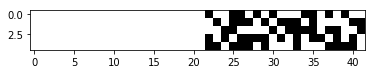

Predicted


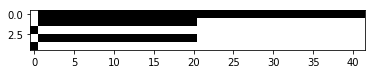

L
Autograd ArrayBox with value [[ 0.          0.10748918  0.08253019  0.0658863   0.05572797  0.04986149
   0.0465823   0.04478127  0.04379752  0.04325745]
 [ 0.10746573  0.          0.06992816  0.05759231  0.04967337  0.04495765
   0.04227492  0.04078708  0.0399701   0.03952023]
 [ 0.08249932  0.06991769  0.          0.04954311  0.04356642  0.03989582
   0.03776927  0.03657771  0.0359197   0.03555622]
 [ 0.0658568   0.05757995  0.04954004  0.          0.0384309   0.03554597
   0.0338482   0.03288831  0.03235557  0.03206046]
 [ 0.05570282  0.0496628   0.04356377  0.03843084  0.          0.03236022
   0.0309472   0.03014296  0.02969493  0.02944623]
 [ 0.04984075  0.0449497   0.03989464  0.03554685  0.03236099  0.
   0.02904951  0.0283398   0.02794347  0.02772316]
 [ 0.04656503  0.04226928  0.03776955  0.03385009  0.03094881  0.0290503
   0.          0.02725102  0.02688438  0.0266804 ]
 [ 0.04476638  0.04078311  0.03657911  0.03289101  0.03014524  0.02834121
   0.02725162  0.          0.

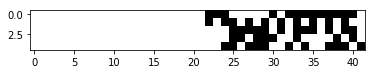

Predicted


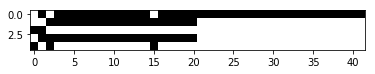

L
Autograd ArrayBox with value [[ 0.          0.1074929   0.08253023  0.06588489  0.05572645  0.04986036
   0.04658166  0.04478103  0.0437976   0.04325774]
 [ 0.10746891  0.          0.06992682  0.05759019  0.04967134  0.04495608
   0.04227384  0.0407864   0.03996971  0.03952005]
 [ 0.0824987   0.06991614  0.          0.04954045  0.04356401  0.03989389
   0.03776781  0.03657662  0.03591888  0.03555559]
 [ 0.0658548   0.05757762  0.04953735  0.          0.03842848  0.03554402
   0.03384668  0.03288712  0.03235463  0.03205969]
 [ 0.05570084  0.04966063  0.04356136  0.03842845  0.          0.03235856
   0.03094594  0.030142    0.02969419  0.02944563]
 [ 0.04983929  0.04494807  0.03989275  0.03554495  0.03235936  0.
   0.02904862  0.02833919  0.02794305  0.02772287]
 [ 0.04656414  0.04226819  0.03776817  0.03384867  0.03094761  0.02904944
   0.          0.02725074  0.02688428  0.02668043]
 [ 0.04476596  0.04078246  0.03657813  0.03288994  0.03014436  0.02834065
   0.02725136  0.          0

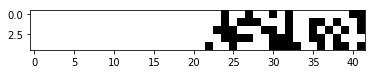

Predicted


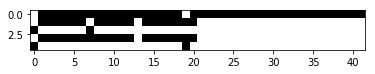

L
Autograd ArrayBox with value [[ 0.          0.10747893  0.08252992  0.06588994  0.05573188  0.04986427
   0.04658379  0.04478172  0.04379727  0.04325669]
 [ 0.10745711  0.          0.069932    0.05759825  0.04967892  0.04496184
   0.04227772  0.04078882  0.03997113  0.03952078]
 [ 0.08250113  0.06992216  0.          0.04955057  0.04357302  0.03990102
   0.03777317  0.03658066  0.03592203  0.03555815]
 [ 0.06586234  0.05758654  0.04954761  0.          0.03843746  0.03555132
   0.03385248  0.03289182  0.0323586   0.03206318]
 [ 0.05570827  0.04966879  0.04357038  0.03843736  0.          0.03236507
   0.03095124  0.03014641  0.02969801  0.02944908]
 [ 0.04984472  0.04495411  0.03989973  0.03555209  0.0323658   0.
   0.02905305  0.0283429   0.02794628  0.02772579]
 [ 0.04656742  0.0422721   0.03777324  0.03385423  0.03095278  0.02905382
   0.          0.02725372  0.02688686  0.02668274]
 [ 0.04476757  0.04078475  0.03658178  0.03289435  0.03014861  0.02834427
   0.02725432  0.          0

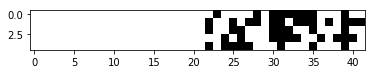

Predicted


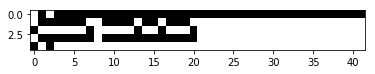

L
Autograd ArrayBox with value [[ 0.          0.10746981  0.08252997  0.0658936   0.05573584  0.04986725
   0.04658556  0.04478245  0.04379721  0.04325608]
 [ 0.10744906  0.          0.06993557  0.05760347  0.04968357  0.0449651
   0.0422796   0.04078958  0.03997106  0.03952016]
 [ 0.08250239  0.06992589  0.          0.04955666  0.04357797  0.03990435
   0.03777503  0.03658137  0.03592192  0.03555749]
 [ 0.06586693  0.05759168  0.04955347  0.          0.03844194  0.03555424
   0.033854    0.03289226  0.03235826  0.03206233]
 [ 0.0557128   0.04967306  0.04357483  0.03844156  0.          0.03236691
   0.03095183  0.03014603  0.02969694  0.02944753]
 [ 0.04984798  0.04495674  0.03990232  0.03555451  0.03236741  0.
   0.0290524   0.02834138  0.02794413  0.02772322]
 [ 0.04656928  0.04227317  0.03777419  0.03385507  0.03095297  0.029053    0.
   0.02725113  0.02688368  0.02667917]
 [ 0.04476824  0.04078458  0.03658147  0.03289399  0.03014772  0.02834248
   0.02725161  0.          0.02627426

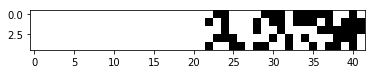

Predicted


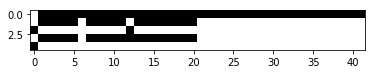

L
Autograd ArrayBox with value [[ 0.          0.1074852   0.08252967  0.06588738  0.05572937  0.04986263
   0.04658304  0.04478161  0.0437975   0.04325709]
 [ 0.10746231  0.          0.06992957  0.05759481  0.04967578  0.04495944
   0.04227601  0.04078757  0.03997011  0.03951987]
 [ 0.08249963  0.06991943  0.          0.04954713  0.04357001  0.03989849
   0.03777101  0.03657871  0.03592016  0.03555628]
 [ 0.0658587   0.05758279  0.04954408  0.          0.03843491  0.03554906
   0.03385037  0.03288974  0.03235647  0.03206098]
 [ 0.05570491  0.04966537  0.0435672   0.03843469  0.          0.03236297
   0.03094916  0.03014427  0.02969577  0.02944673]
 [ 0.04984243  0.04495144  0.03989693  0.03554958  0.03236355  0.
   0.02905083  0.02834058  0.02794383  0.02772322]
 [ 0.04656617  0.04227013  0.03777073  0.03385174  0.03095043  0.02905148
   0.          0.02725116  0.02688415  0.02667991]
 [ 0.04476705  0.04078325  0.03657943  0.03289181  0.0301461   0.02834173
   0.02725166  0.          0

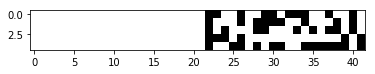

Predicted


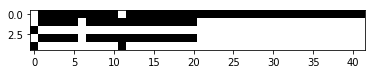

L
Autograd ArrayBox with value [[ 0.          0.10747486  0.08252927  0.06589097  0.05573335  0.0498656
   0.04658477  0.04478231  0.04379747  0.04325658]
 [ 0.10745349  0.          0.06993283  0.05760019  0.04968096  0.04496348
   0.04227883  0.04078942  0.03997128  0.03952059]
 [ 0.08250114  0.06992322  0.          0.04955361  0.04357582  0.03990314
   0.03777454  0.03658138  0.03592223  0.03555796]
 [ 0.06586402  0.05758871  0.04955063  0.          0.03844058  0.03555365
   0.03385399  0.03289262  0.03235885  0.03206304]
 [ 0.05571031  0.04967094  0.04357303  0.03844033  0.          0.03236697
   0.03095234  0.03014682  0.0296979   0.02944859]
 [ 0.04984653  0.04495572  0.03990152  0.0355541   0.03236752  0.
   0.02905334  0.02834255  0.02794544  0.02772459]
 [ 0.04656882  0.04227307  0.03777414  0.03385525  0.03095354  0.02905396
   0.          0.02725256  0.02688523  0.02668077]
 [ 0.04476851  0.04078513  0.03658193  0.03289455  0.03014857  0.02834366
   0.02725305  0.          0.

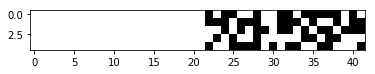

Predicted


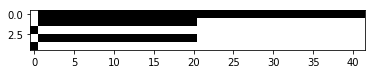

L
Autograd ArrayBox with value [[ 0.          0.10749556  0.08253082  0.06588443  0.05572569  0.04985968
   0.04658118  0.04478077  0.04379752  0.04325779]
 [ 0.10747107  0.          0.06992677  0.05758926  0.04966997  0.04495462
   0.04227246  0.04078516  0.0399686   0.03951904]
 [ 0.08249853  0.06991572  0.          0.04953872  0.04356181  0.03989149
   0.0377654   0.03657428  0.03591663  0.03555342]
 [ 0.06585351  0.05757609  0.04953535  0.          0.03842549  0.03554084
   0.03384348  0.03288398  0.03235156  0.03205669]
 [ 0.05569926  0.04965856  0.04355872  0.03842529  0.          0.03235491
   0.03094229  0.03013841  0.02969068  0.02944219]
 [ 0.04983782  0.04494586  0.03988984  0.03554152  0.03235562  0.
   0.0290448   0.02833545  0.02793939  0.02771927]
 [ 0.04656292  0.04226605  0.03776521  0.03384517  0.03094383  0.02904558
   0.          0.027247    0.02688062  0.02667683]
 [ 0.04476499  0.04078047  0.03657523  0.03288649  0.03014063  0.02833685
   0.0272476   0.          0

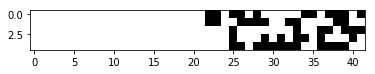

Predicted


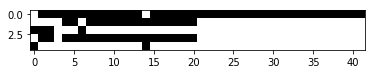

L
Autograd ArrayBox with value [[ 0.          0.107478    0.08252901  0.06588942  0.05573178  0.0498645
   0.04658422  0.04478226  0.0437978   0.04325713]
 [ 0.10745623  0.          0.06993099  0.05759787  0.04967904  0.04496225
   0.04227829  0.04078945  0.03997173  0.03952131]
 [ 0.08250046  0.06992135  0.          0.0495508   0.04357349  0.03990149
   0.03777356  0.03658095  0.03592221  0.03555821]
 [ 0.06586224  0.05758651  0.04954793  0.          0.038438    0.03555161
   0.0338525   0.03289162  0.03235822  0.03206265]
 [ 0.05570871  0.04966931  0.04357092  0.03843786  0.          0.03236491
   0.03095072  0.03014562  0.02969702  0.02944792]
 [ 0.04984556  0.04495493  0.03990021  0.03555226  0.03236555  0.
   0.02905195  0.02834151  0.02794468  0.02772403]
 [ 0.04656853  0.04227308  0.03777359  0.03385405  0.0309521   0.02905265
   0.          0.02725186  0.02688478  0.02668051]
 [ 0.04476881  0.04078579  0.036582    0.03289389  0.03014759  0.02834276
   0.0272524   0.          0.

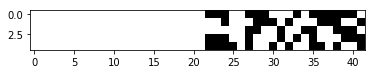

Predicted


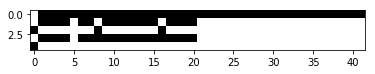

L
Autograd ArrayBox with value [[ 0.          0.10748039  0.08252916  0.06588869  0.05573097  0.04986387
   0.04658378  0.04478194  0.04379755  0.04325696]
 [ 0.10745835  0.          0.06993044  0.05759689  0.04967814  0.04496161
   0.04227785  0.04078912  0.03997146  0.03952109]
 [ 0.08250027  0.06992075  0.          0.04954991  0.043573    0.03990141
   0.03777376  0.03658129  0.03592261  0.03555865]
 [ 0.06586119  0.05758551  0.04954712  0.          0.03843833  0.03555245
   0.03385365  0.03289293  0.03235958  0.03206404]
 [ 0.0557076   0.04966845  0.04357059  0.03843828  0.          0.03236661
   0.03095272  0.03014776  0.02969921  0.02945014]
 [ 0.04984466  0.04495435  0.03990034  0.03555323  0.03236729  0.
   0.02905451  0.0283442   0.02794742  0.02772678]
 [ 0.04656783  0.04227272  0.03777401  0.03385536  0.03095417  0.02905522
   0.          0.02725483  0.02688779  0.02668353]
 [ 0.04476823  0.04078553  0.03658256  0.03289536  0.03014981  0.02834547
   0.02725537  0.          0

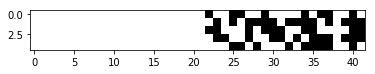

Predicted


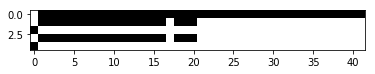

L
Autograd ArrayBox with value [[ 0.          0.1074906   0.08253025  0.06588583  0.05572746  0.04986111
   0.04658209  0.04478118  0.04379749  0.04325741]
 [ 0.10746686  0.          0.06992816  0.05759197  0.04967279  0.04495693
   0.04227413  0.04078625  0.03996922  0.0395193 ]
 [ 0.08249901  0.06991753  0.          0.04954292  0.0435659   0.03989497
   0.03776816  0.03657642  0.03591829  0.03555472]
 [ 0.06585596  0.05757934  0.04953969  0.          0.03843028  0.03554501
   0.03384695  0.03288685  0.03235397  0.03205876]
 [ 0.05570194  0.04966182  0.04356292  0.03843005  0.          0.03235901
   0.03094575  0.03014133  0.02969318  0.02944438]
 [ 0.04984001  0.04494849  0.03989331  0.03554558  0.03235964  0.
   0.02904779  0.02833795  0.02794151  0.02772111]
 [ 0.04656446  0.04226792  0.03776787  0.03384844  0.03094713  0.02904849
   0.          0.02724895  0.02688222  0.02667818]
 [ 0.04476594  0.04078166  0.03657719  0.03288908  0.03014331  0.0283392
   0.02724949  0.          0.

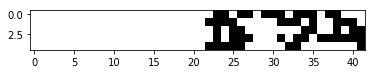

Predicted


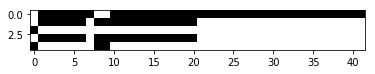

L
Autograd ArrayBox with value [[ 0.          0.10747635  0.08252856  0.06588962  0.0557322   0.04986488
   0.04658446  0.04478232  0.04379773  0.04325702]
 [ 0.107455    0.          0.06993083  0.05759834  0.04967995  0.04496336
   0.04227943  0.04079053  0.03997274  0.0395223 ]
 [ 0.08250065  0.06992153  0.          0.04955184  0.04357514  0.03990356
   0.03777583  0.03658327  0.03592453  0.03556054]
 [ 0.06586316  0.05758755  0.04954927  0.          0.03844063  0.03555472
   0.03385587  0.03289509  0.03236171  0.03206616]
 [ 0.05570984  0.04967092  0.04357308  0.03844071  0.          0.03236891
   0.03095497  0.03014997  0.02970139  0.02945231]
 [ 0.04984663  0.04495681  0.03990291  0.03555573  0.03236969  0.
   0.02905677  0.02834641  0.0279496   0.02772895]
 [ 0.04656942  0.04227502  0.03777656  0.03385786  0.03095657  0.02905754
   0.          0.02725703  0.02688997  0.0266857 ]
 [ 0.04476949  0.04078767  0.03658505  0.03289784  0.0301522   0.02834777
   0.02725761  0.          0

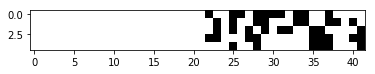

Predicted


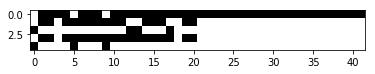

L
Autograd ArrayBox with value [[ 0.          0.10746173  0.08252848  0.06589517  0.0557381   0.04986912
   0.04658676  0.04478307  0.04379738  0.04325589]
 [ 0.10744252  0.          0.06993654  0.05760689  0.04968779  0.04496916
   0.04228316  0.04079266  0.03997378  0.03952259]
 [ 0.08250319  0.06992794  0.          0.04956227  0.04358418  0.03991047
   0.03778078  0.03658676  0.03592703  0.03556239]
 [ 0.06587099  0.05759669  0.04955971  0.          0.03844941  0.0355616
   0.03386107  0.03289905  0.03236485  0.03206876]
 [ 0.05571747  0.04967903  0.04358194  0.03844935  0.          0.03237479
   0.03095947  0.03015345  0.0297042   0.02945468]
 [ 0.04985209  0.04496253  0.03990943  0.03556232  0.03237544  0.
   0.02906019  0.02834899  0.02795162  0.02773061]
 [ 0.04657257  0.04227842  0.03778095  0.03386266  0.03096086  0.02906088
   0.          0.02725873  0.02689118  0.02668659]
 [ 0.04477085  0.0407893   0.03658787  0.03290134  0.03015542  0.02835023
   0.02725926  0.          0.

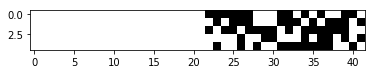

Predicted


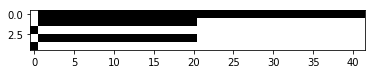

L
Autograd ArrayBox with value [[ 0.          0.10750275  0.08253124  0.06588209  0.05572304  0.0498577
   0.04658002  0.04478028  0.0437975   0.04325811]
 [ 0.10747716  0.          0.06992454  0.05758546  0.04966631  0.04495177
   0.04227048  0.04078386  0.03996777  0.03951853]
 [ 0.08249752  0.06991304  0.          0.04953397  0.04355764  0.03988827
   0.03776305  0.03657259  0.03591538  0.03555245]
 [ 0.06584981  0.05757183  0.04953054  0.          0.03842156  0.03553783
   0.03384127  0.03288235  0.0323503   0.03205567]
 [ 0.05569546  0.04965454  0.04355457  0.03842142  0.          0.0323525
   0.03094055  0.03013716  0.02968973  0.02944144]
 [ 0.0498349   0.0449428   0.03988674  0.03553864  0.03235328  0.
   0.02904364  0.02833469  0.02793888  0.02771893]
 [ 0.04656097  0.04226398  0.03776307  0.03384315  0.0309422   0.02904446
   0.          0.02724668  0.02688053  0.02667688]
 [ 0.04476382  0.04077915  0.0365738   0.03288508  0.03013951  0.02833615
   0.02724731  0.          0.0

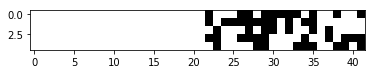

Predicted


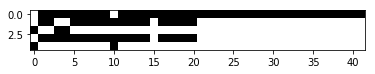

L
Autograd ArrayBox with value [[ 0.          0.10747439  0.08252907  0.06589085  0.05573327  0.04986553
   0.04658473  0.04478236  0.04379768  0.04325694]
 [ 0.1074532   0.          0.06993222  0.05759968  0.04968072  0.04496356
   0.04227919  0.04079005  0.03997217  0.0395217 ]
 [ 0.08250119  0.0699227   0.          0.04955248  0.04357497  0.03990276
   0.03777463  0.03658186  0.03592305  0.03555904]
 [ 0.06586424  0.05758842  0.04954963  0.          0.03843934  0.03555289
   0.03385373  0.0328928   0.03235939  0.03206385]
 [ 0.05571064  0.04967108  0.04357248  0.03843927  0.          0.03236636
   0.03095221  0.03014711  0.02969853  0.02944947]
 [ 0.04984693  0.04495632  0.03990161  0.03555368  0.03236708  0.
   0.02905368  0.02834328  0.02794648  0.02772587]
 [ 0.04656929  0.04227407  0.03777483  0.03385548  0.03095373  0.02905444
   0.          0.02725381  0.02688677  0.02668253]
 [ 0.04476911  0.04078647  0.03658311  0.03289532  0.03014927  0.02834463
   0.02725439  0.          0

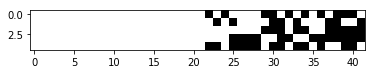

Predicted


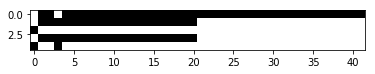

L
Autograd ArrayBox with value [[ 0.          0.10749474  0.08252872  0.06588273  0.05572486  0.04985958
   0.04658152  0.04478126  0.04379795  0.04325812]
 [ 0.10747075  0.          0.06992394  0.05758804  0.04967058  0.04495652
   0.04227508  0.04078807  0.03997154  0.03952191]
 [ 0.08249761  0.0699139   0.          0.04953998  0.04356526  0.03989638
   0.03777103  0.0365802   0.03592257  0.03555928]
 [ 0.06585348  0.05757671  0.04953753  0.          0.03843197  0.03554854
   0.03385175  0.03289243  0.03235997  0.032065  ]
 [ 0.05570037  0.04966145  0.04356362  0.0384323   0.          0.03236452
   0.03095227  0.03014846  0.02970065  0.02945203]
 [ 0.04983979  0.04495025  0.0398964   0.03554999  0.03236546  0.
   0.02905561  0.02834624  0.02795007  0.02772981]
 [ 0.04656537  0.04227124  0.0377726   0.03385429  0.03095413  0.02905647
   0.          0.027258    0.02689149  0.02668755]
 [ 0.04476761  0.04078597  0.03658292  0.0328958   0.03015101  0.02834774
   0.02725862  0.          0

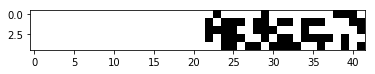

Predicted


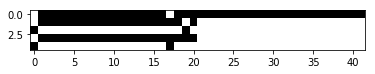

L
Autograd ArrayBox with value [[ 0.          0.10748417  0.08253079  0.06588884  0.05573039  0.04986309
   0.04658305  0.04478137  0.04379723  0.04325691]
 [ 0.1074613   0.          0.06993121  0.05759582  0.04967597  0.04495902
   0.04227523  0.04078665  0.03996921  0.03951908]
 [ 0.08250047  0.06992061  0.          0.04954648  0.04356849  0.03989655
   0.03776895  0.03657667  0.03591823  0.03555451]
 [ 0.06585958  0.05758298  0.04954306  0.          0.03843196  0.03554591
   0.03384728  0.0328868   0.0323537   0.0320584 ]
 [ 0.05570519  0.0496646   0.0435652   0.03843164  0.          0.03235934
   0.03094567  0.03014098  0.02969268  0.02944383]
 [ 0.04984206  0.04495005  0.03989454  0.03554635  0.03235995  0.
   0.02904742  0.02833738  0.02794084  0.02772041]
 [ 0.04656532  0.04226843  0.03776828  0.03384865  0.03094704  0.02904813
   0.          0.02724823  0.02688142  0.02667735]
 [ 0.04476592  0.04078143  0.03657706  0.03288892  0.03014298  0.02833866
   0.02724879  0.          0

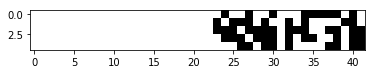

Predicted


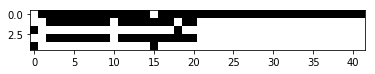

L
Autograd ArrayBox with value [[ 0.          0.10749043  0.08252912  0.06588475  0.05572678  0.04986082
   0.04658205  0.04478128  0.04379766  0.04325765]
 [ 0.1074671   0.          0.0699262   0.05759086  0.0496729   0.04495805
   0.04227591  0.04078841  0.03997158  0.03952179]
 [ 0.08249872  0.06991624  0.          0.04954285  0.04356749  0.03989791
   0.03777201  0.03658081  0.03592297  0.03555957]
 [ 0.06585602  0.05757949  0.04954032  0.          0.03843377  0.03554982
   0.03385264  0.03289307  0.03236049  0.03206545]
 [ 0.05570259  0.0496636   0.0435657   0.03843406  0.          0.03236548
   0.03095298  0.03014902  0.02970112  0.02945248]
 [ 0.04984114  0.04495152  0.03989776  0.03555122  0.03236643  0.
   0.02905616  0.0283467   0.02795048  0.02773022]
 [ 0.04656589  0.04227174  0.03777339  0.03385515  0.03095487  0.02905705
   0.          0.0272584   0.02689186  0.02668793]
 [ 0.04476752  0.04078593  0.03658334  0.03289643  0.03015161  0.02834824
   0.02725904  0.          0

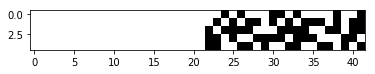

Predicted


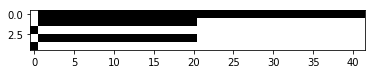

L
Autograd ArrayBox with value [[ 0.          0.10750009  0.08253093  0.06588282  0.05572394  0.04985837
   0.04658039  0.04478038  0.0437974   0.04325789]
 [ 0.10747501  0.          0.06992527  0.05758688  0.0496678   0.04495304
   0.04227145  0.04078457  0.03996829  0.03951893]
 [ 0.08249792  0.06991406  0.          0.04953602  0.0435597   0.03989014
   0.03776468  0.036574    0.03591663  0.03555359]
 [ 0.06585126  0.05757362  0.04953272  0.          0.03842399  0.03554014
   0.03384339  0.0328843   0.03235213  0.03205741]
 [ 0.05569699  0.0496564   0.04355681  0.03842391  0.          0.03235502
   0.03094294  0.03013941  0.02969189  0.02944352]
 [ 0.04983611  0.04494439  0.03988878  0.03554102  0.03235581  0.
   0.02904609  0.02833704  0.02794115  0.02772114]
 [ 0.0465618   0.04226522  0.03776485  0.03384535  0.03094462  0.02904692
   0.          0.02724901  0.02688278  0.02667908]
 [ 0.04476432  0.04078009  0.03657534  0.0328871   0.03014179  0.02833851
   0.02724963  0.          0

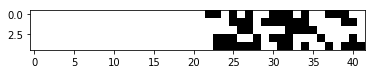

Predicted


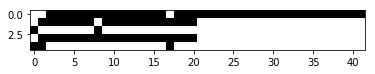

L
Autograd ArrayBox with value [[ 0.          0.10747974  0.08253069  0.06589045  0.05573216  0.04986441
   0.04658385  0.04478172  0.04379723  0.04325664]
 [ 0.10745746  0.          0.06993285  0.05759836  0.04967829  0.0449607
   0.04227628  0.0407872   0.03996939  0.03951899]
 [ 0.08250107  0.06992243  0.          0.04954968  0.04357117  0.03989845
   0.03777014  0.03657733  0.03591852  0.03555453]
 [ 0.06586181  0.05758564  0.04954621  0.          0.03843443  0.03554758
   0.03384825  0.03288726  0.03235382  0.03205828]
 [ 0.05570741  0.04966691  0.0435677   0.03843398  0.          0.03236035
   0.03094605  0.03014091  0.0296923   0.02944324]
 [ 0.0498437   0.0449516   0.03989614  0.03554779  0.03236085  0.
   0.02904711  0.02833667  0.02793985  0.02771923]
 [ 0.04656633  0.04226924  0.03776909  0.0338493   0.03094724  0.02904775
   0.          0.02724697  0.02687992  0.02667568]
 [ 0.04476643  0.04078168  0.03657728  0.03288902  0.03014267  0.02833783
   0.02724749  0.          0.

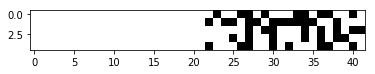

Predicted


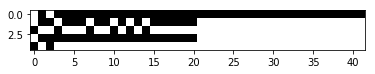

L
Autograd ArrayBox with value [[ 0.          0.10746546  0.08252842  0.06589368  0.05573658  0.04986811
   0.04658634  0.04478312  0.04379777  0.04325649]
 [ 0.10744553  0.          0.06993486  0.05760442  0.04968543  0.04496729
   0.04228184  0.04079179  0.03997322  0.03952223]
 [ 0.08250223  0.06992592  0.          0.04955893  0.04358087  0.03990746
   0.03777814  0.03658444  0.03592494  0.03556045]
 [ 0.06586869  0.05759381  0.04955619  0.          0.03844538  0.03555769
   0.03385737  0.03289555  0.0323615   0.03206551]
 [ 0.05571533  0.04967629  0.04357838  0.03844521  0.          0.03237038
   0.03095517  0.03014927  0.02970012  0.02945067]
 [ 0.04985064  0.04496036  0.03990615  0.03555825  0.03237097  0.
   0.02905562  0.0283445   0.0279472   0.02772624]
 [ 0.04657184  0.04227686  0.03777805  0.03385877  0.03095645  0.02905627
   0.          0.02725414  0.02688664  0.02668209]
 [ 0.04477068  0.04078824  0.0365853   0.03289763  0.03015112  0.02834568
   0.02725465  0.          0

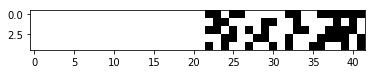

Predicted


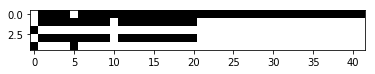

L
Autograd ArrayBox with value [[ 0.          0.10747713  0.0825283   0.06588908  0.05573173  0.04986457
   0.04658428  0.04478221  0.04379765  0.04325693]
 [ 0.10745582  0.          0.06993026  0.05759793  0.04967989  0.04496361
   0.04227987  0.04079106  0.0399733   0.03952285]
 [ 0.08250055  0.06992119  0.          0.04955212  0.04357599  0.03990482
   0.03777733  0.03658489  0.03592618  0.03556219]
 [ 0.06586287  0.05758757  0.04954979  0.          0.03844244  0.03555695
   0.03385833  0.03289766  0.03236432  0.03206877]
 [ 0.05570967  0.04967141  0.04357433  0.03844269  0.          0.03237185
   0.03095811  0.0301532   0.02970465  0.02945557]
 [ 0.04984663  0.04495764  0.03990464  0.0355582   0.03237271  0.
   0.02906029  0.02835002  0.02795323  0.02773259]
 [ 0.04656955  0.04227605  0.03777854  0.03386059  0.03095981  0.0290611
   0.          0.02726083  0.02689379  0.02668952]
 [ 0.0447697   0.04078879  0.03658714  0.03290069  0.03015555  0.02835142
   0.02726142  0.          0.

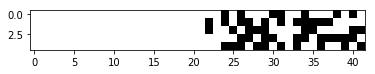

Predicted


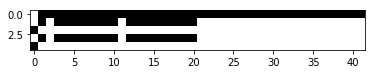

L
Autograd ArrayBox with value [[ 0.          0.10748019  0.08252916  0.06588868  0.05573091  0.0498638
   0.04658376  0.04478202  0.04379778  0.04325732]
 [ 0.10745817  0.          0.06993012  0.05759645  0.04967771  0.04496131
   0.04227775  0.04078924  0.03997179  0.03952159]
 [ 0.08250027  0.06992036  0.          0.04954865  0.04357165  0.03990023
   0.03777285  0.03658067  0.03592225  0.0355585 ]
 [ 0.0658612   0.05758499  0.04954581  0.          0.03843612  0.03555036
   0.03385184  0.03289141  0.03235833  0.032063  ]
 [ 0.05570761  0.04966801  0.04356925  0.03843611  0.          0.0323641
   0.03095045  0.03014577  0.02969746  0.02944858]
 [ 0.04984471  0.04495413  0.03989925  0.03555126  0.03236487  0.
   0.02905225  0.02834218  0.02794562  0.02772517]
 [ 0.04656798  0.04227277  0.03777329  0.03385375  0.03095206  0.02905304
   0.          0.02725302  0.02688619  0.02668209]
 [ 0.04476852  0.04078587  0.0365822   0.03289412  0.03014804  0.02834359
   0.02725363  0.          0.0

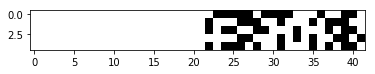

Predicted


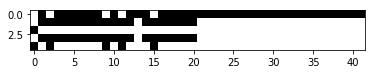

L
Autograd ArrayBox with value [[ 0.          0.10747593  0.08252937  0.06589054  0.05573277  0.04986506
   0.04658438  0.04478214  0.04379755  0.04325685]
 [ 0.10745452  0.          0.06993223  0.05759927  0.04968014  0.04496296
   0.04227868  0.04078963  0.03997181  0.03952138]
 [ 0.0825012   0.06992262  0.          0.04955193  0.04357433  0.03990213
   0.03777406  0.03658138  0.03592264  0.03555867]
 [ 0.06586361  0.05758786  0.04954904  0.          0.03843857  0.03555212
   0.03385302  0.03289218  0.03235883  0.03206333]
 [ 0.05570981  0.04967033  0.04357176  0.03843847  0.          0.03236545
   0.03095133  0.03014631  0.02969779  0.02944878]
 [ 0.04984614  0.04495554  0.03990089  0.03555288  0.03236616  0.
   0.02905274  0.0283424   0.02794566  0.02772509]
 [ 0.04656863  0.04227336  0.03777418  0.03385474  0.03095284  0.02905349
   0.          0.02725293  0.02688595  0.02668175]
 [ 0.04476858  0.04078585  0.03658255  0.03289466  0.03014847  0.02834375
   0.02725352  0.          0

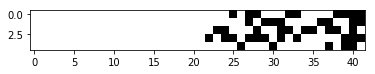

Predicted


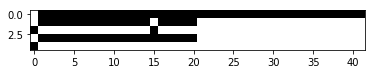

L
Autograd ArrayBox with value [[ 0.          0.10746686  0.08252856  0.06589327  0.05573602  0.04986756
   0.04658583  0.04478264  0.04379728  0.043256  ]
 [ 0.10744703  0.          0.06993486  0.05760433  0.04968551  0.04496754
   0.0422822   0.04079219  0.03997363  0.03952263]
 [ 0.08250256  0.06992618  0.          0.04955966  0.0435822   0.03990925
   0.03778021  0.03658666  0.03592723  0.03556276]
 [ 0.0658685   0.05759419  0.04955723  0.          0.03844805  0.03556095
   0.03386099  0.03289938  0.03236543  0.0320695 ]
 [ 0.05571496  0.04967693  0.04358021  0.03844811  0.          0.03237474
   0.0309599   0.03015422  0.02970519  0.02945579]
 [ 0.04985023  0.04496118  0.03990854  0.03556186  0.03237546  0.
   0.02906107  0.02835017  0.02795298  0.02773208]
 [ 0.04657142  0.04227777  0.03778075  0.03386281  0.03096139  0.0290618
   0.          0.02726024  0.02689285  0.02668836]
 [ 0.04477026  0.04078918  0.03658816  0.03290191  0.03015632  0.02835146
   0.02726079  0.          0.

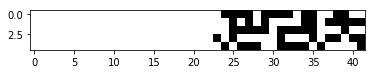

Predicted


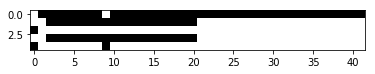

L
Autograd ArrayBox with value [[ 0.          0.1074897   0.08253109  0.06588696  0.05572822  0.04986141
   0.04658204  0.04478093  0.04379719  0.04325711]
 [ 0.10746608  0.          0.06992958  0.05759306  0.04967332  0.04495699
   0.04227389  0.04078587  0.03996882  0.03951893]
 [ 0.08249982  0.06991876  0.          0.04954328  0.04356572  0.03989448
   0.03776755  0.03657581  0.03591774  0.03555425]
 [ 0.06585684  0.05758005  0.04953989  0.          0.03842937  0.03554394
   0.0338459   0.0328859   0.03235314  0.03205805]
 [ 0.05570232  0.04966189  0.04356254  0.03842911  0.          0.03235765
   0.03094448  0.0301402   0.02969219  0.02944352]
 [ 0.04983983  0.04494805  0.03989264  0.03554452  0.03235832  0.
   0.02904657  0.02833688  0.02794059  0.02772032]
 [ 0.04656387  0.04226719  0.03776712  0.03384745  0.03094596  0.02904732
   0.          0.02724807  0.02688149  0.02667758]
 [ 0.04476513  0.04078081  0.03657648  0.03288824  0.03014233  0.02833824
   0.02724866  0.          0

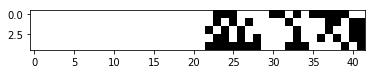

Predicted


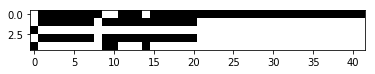

L
Autograd ArrayBox with value [[ 0.          0.1074746   0.08252923  0.06589098  0.05573334  0.04986552
   0.04658465  0.0447822   0.04379742  0.04325656]
 [ 0.1074534   0.          0.06993284  0.05760027  0.04968113  0.04496371
   0.04227913  0.04078979  0.03997174  0.03952113]
 [ 0.08250136  0.06992336  0.          0.04955361  0.04357594  0.03990343
   0.03777501  0.036582    0.03592299  0.03555883]
 [ 0.06586433  0.05758901  0.04955075  0.          0.03844061  0.03555389
   0.03385443  0.03289326  0.03235965  0.03206396]
 [ 0.05571058  0.04967139  0.04357335  0.03844047  0.          0.03236729
   0.03095286  0.03014754  0.02969877  0.02944957]
 [ 0.04984672  0.04495627  0.03990209  0.03555452  0.03236793  0.
   0.02905407  0.02834345  0.02794648  0.02772575]
 [ 0.04656896  0.04227371  0.03777494  0.03385595  0.03095423  0.02905476
   0.          0.02725369  0.0268865   0.02668214]
 [ 0.04476865  0.04078585  0.03658292  0.03289549  0.03014949  0.02834469
   0.02725423  0.          0

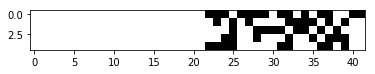

Predicted


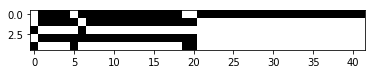

L
Autograd ArrayBox with value [[ 0.          0.10747237  0.08252947  0.06589205  0.05573438  0.04986625
   0.04658506  0.04478236  0.04379743  0.04325653]
 [ 0.10745143  0.          0.06993357  0.05760127  0.04968203  0.04496441
   0.04227964  0.04079017  0.03997204  0.0395214 ]
 [ 0.0825018   0.06992405  0.          0.04955435  0.04357659  0.039904
   0.03777552  0.03658248  0.03592346  0.03555931]
 [ 0.0658655   0.05758993  0.04955147  0.          0.03844114  0.03555441
   0.03385498  0.03289383  0.03236024  0.03206458]
 [ 0.05571167  0.04967223  0.04357402  0.03844104  0.          0.03236789
   0.03095351  0.03014823  0.0296995   0.02945034]
 [ 0.04984747  0.04495695  0.03990274  0.03555515  0.03236858  0.
   0.02905486  0.0283443   0.02794738  0.02772668]
 [ 0.04656936  0.04227424  0.03777559  0.03385666  0.03095499  0.0290556
   0.          0.02725467  0.02688753  0.02668322]
 [ 0.0447688   0.04078628  0.03658358  0.03289626  0.03015034  0.02834562
   0.02725524  0.          0.02

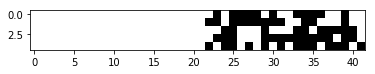

Predicted


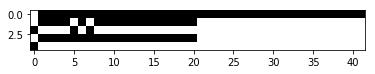

L
Autograd ArrayBox with value [[ 0.          0.10750163  0.08252984  0.06588116  0.05572272  0.04985784
   0.04658042  0.04478076  0.04379796  0.04325853]
 [ 0.10747638  0.          0.06992265  0.05758467  0.04966667  0.04495295
   0.04227213  0.04078571  0.03996967  0.03952042]
 [ 0.08249686  0.06991172  0.          0.0495344   0.04355932  0.03989079
   0.03776602  0.03657574  0.03591856  0.03555561]
 [ 0.06584994  0.05757209  0.04953148  0.          0.03842473  0.03554166
   0.03384541  0.03288658  0.03235452  0.03205984]
 [ 0.0556964   0.04965625  0.04355707  0.03842488  0.          0.03235727
   0.03094551  0.03014214  0.02969467  0.02944631]
 [ 0.04983639  0.04494548  0.03989021  0.03554289  0.03235817  0.          0.029049
   0.02834003  0.02794416  0.02772413]
 [ 0.04656278  0.0422672   0.03776704  0.03384776  0.03094733  0.02904986
   0.          0.02725212  0.02688588  0.02668215]
 [ 0.04476573  0.04078261  0.03657797  0.03288979  0.03014467  0.02834155
   0.02725275  0.     

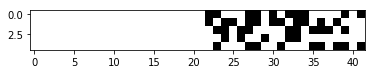

Predicted


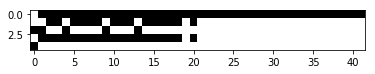

L
Autograd ArrayBox with value [[ 0.          0.10746744  0.08252948  0.06589399  0.05573645  0.04986777
   0.04658593  0.04478269  0.04379737  0.04325616]
 [ 0.10744711  0.          0.06993572  0.05760431  0.04968464  0.04496615
   0.04228053  0.04079042  0.03997184  0.03952089]
 [ 0.08250253  0.06992632  0.          0.04955793  0.04357933  0.03990566
   0.03777623  0.0365825   0.03592301  0.03555855]
 [ 0.06586802  0.05759294  0.04955489  0.          0.03844334  0.03555554
   0.0338552   0.03289339  0.03235937  0.03206342]
 [ 0.05571411  0.04967459  0.04357639  0.03844302  0.          0.03236811
   0.03095293  0.03014708  0.02969796  0.02944855]
 [ 0.04984918  0.04495824  0.03990384  0.03555589  0.03236864  0.
   0.02905342  0.02834236  0.02794509  0.02772417]
 [ 0.04657029  0.04227456  0.03777562  0.03385638  0.03095413  0.02905405
   0.          0.02725206  0.0268846   0.02668008]
 [ 0.04476911  0.04078587  0.03658283  0.03289525  0.03014884  0.0283435
   0.02725256  0.          0.

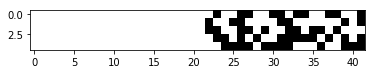

Predicted


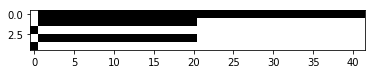

L
Autograd ArrayBox with value [[ 0.          0.10748364  0.08252964  0.06588788  0.05572988  0.04986294
   0.04658314  0.04478155  0.04379739  0.04325701]
 [ 0.10746121  0.          0.06992952  0.05759517  0.04967652  0.04496046
   0.0422772   0.04078888  0.03997151  0.03952138]
 [ 0.08250018  0.06991965  0.          0.04954746  0.04357105  0.03990023
   0.03777329  0.03658134  0.03592303  0.03555933]
 [ 0.06585981  0.05758367  0.04954474  0.          0.03843665  0.0355516
   0.03385353  0.03289334  0.03236036  0.03206508]
 [ 0.05570601  0.04966685  0.0435689   0.03843678  0.          0.03236644
   0.03095321  0.03014874  0.02970052  0.02945167]
 [ 0.04984332  0.04495337  0.03989959  0.03555273  0.03236729  0.
   0.0290557   0.02834582  0.02794933  0.0277289 ]
 [ 0.04656684  0.04227235  0.03777409  0.03385571  0.03095494  0.02905653
   0.          0.02725702  0.02689025  0.02668617]
 [ 0.04476755  0.04078565  0.03658325  0.03289632  0.03015114  0.02834728
   0.02725764  0.          0.

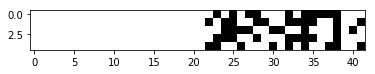

Predicted


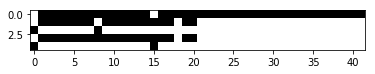

L
Autograd ArrayBox with value [[ 0.          0.10747356  0.08253004  0.06589217  0.05573426  0.04986605
   0.04658485  0.04478218  0.04379728  0.04325641]
 [ 0.10745233  0.          0.06993409  0.05760121  0.0496815   0.04496361
   0.0422787   0.04078917  0.03997104  0.03952041]
 [ 0.08250187  0.06992426  0.          0.0495537   0.04357541  0.03990247
   0.0377738   0.03658066  0.03592161  0.03555745]
 [ 0.06586501  0.05758934  0.04955056  0.          0.03843926  0.03555221
   0.03385258  0.03289134  0.03235771  0.03206203]
 [ 0.05571088  0.04967104  0.04357242  0.03843899  0.          0.03236516
   0.03095062  0.03014525  0.02969649  0.02944731]
 [ 0.04984658  0.04495541  0.0399007   0.03555267  0.03236575  0.
   0.02905164  0.02834101  0.02794405  0.02772334]
 [ 0.04656846  0.04227254  0.03777331  0.03385394  0.03095194  0.02905233
   0.          0.0272512   0.02688402  0.02667969]
 [ 0.04476792  0.04078451  0.03658118  0.03289343  0.03014718  0.02834224
   0.02725174  0.          0

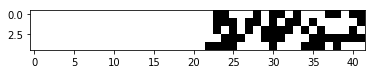

Predicted


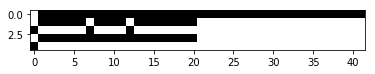

L
Autograd ArrayBox with value [[ 0.          0.10748009  0.08252889  0.06588848  0.05573084  0.04986383
   0.04658383  0.04478207  0.04379778  0.04325731]
 [ 0.10745818  0.          0.0699295   0.05759614  0.04967786  0.04496182
   0.04227847  0.04079004  0.03997261  0.03952242]
 [ 0.08250021  0.06991994  0.          0.04954875  0.04357244  0.03990156
   0.03777451  0.03658248  0.03592411  0.03556038]
 [ 0.06586128  0.05758509  0.04954618  0.          0.03843785  0.03555262
   0.03385441  0.03289412  0.03236109  0.03206578]
 [ 0.05570788  0.04966872  0.0435705   0.03843804  0.          0.03236713
   0.03095373  0.03014915  0.02970088  0.029452  ]
 [ 0.04984512  0.04495529  0.03990115  0.03555384  0.03236801  0.
   0.02905596  0.02834597  0.02794942  0.02772895]
 [ 0.04656844  0.04227421  0.03777558  0.0338567   0.03095551  0.02905681
   0.          0.027257    0.02689016  0.02668605]
 [ 0.04476896  0.04078741  0.03658467  0.03289724  0.03015163  0.02834746
   0.02725763  0.          0

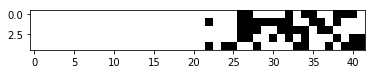

Predicted


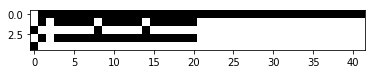

L
Autograd ArrayBox with value [[ 0.          0.1074748   0.08252917  0.06589084  0.05573324  0.04986552
   0.04658473  0.04478232  0.04379755  0.04325669]
 [ 0.1074535   0.          0.06993254  0.05759998  0.04968091  0.04496359
   0.04227907  0.04078978  0.03997174  0.03952112]
 [ 0.08250115  0.06992302  0.          0.04955336  0.04357574  0.03990326
   0.03777485  0.03658185  0.03592282  0.03555864]
 [ 0.06586407  0.05758868  0.04955047  0.          0.03844045  0.03555369
   0.0338542   0.032893    0.03235935  0.03206363]
 [ 0.05571041  0.04967114  0.04357312  0.03844028  0.          0.03236701
   0.03095252  0.03014715  0.02969835  0.02944912]
 [ 0.04984668  0.04495613  0.03990187  0.03555427  0.03236762  0.
   0.02905362  0.02834296  0.02794595  0.02772518]
 [ 0.04656903  0.04227366  0.03777473  0.03385565  0.03095385  0.02905429
   0.          0.02725311  0.02688587  0.02668149]
 [ 0.04476879  0.04078587  0.03658271  0.03289515  0.03014905  0.02834416
   0.02725363  0.          0

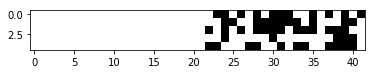

Predicted


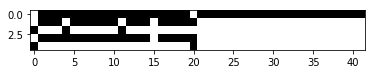

L
Autograd ArrayBox with value [[ 0.          0.10749112  0.08253057  0.06588588  0.05572731  0.04986088
   0.04658188  0.04478107  0.04379754  0.04325759]
 [ 0.10746731  0.          0.06992814  0.05759159  0.04967226  0.04495643
   0.04227377  0.04078608  0.03996925  0.0395195 ]
 [ 0.08249918  0.06991739  0.          0.0495417   0.04356451  0.03989368
   0.03776711  0.03657565  0.03591777  0.03555439]
 [ 0.06585581  0.05757877  0.04953839  0.          0.03842808  0.03554293
   0.03384515  0.03288535  0.03235274  0.03205774]
 [ 0.05570161  0.04966113  0.04356148  0.03842788  0.          0.03235661
   0.03094361  0.03013948  0.02969159  0.029443  ]
 [ 0.04983963  0.04494789  0.03989205  0.03554359  0.03235731  0.
   0.02904575  0.02833617  0.02793998  0.02771977]
 [ 0.04656413  0.04226752  0.03776692  0.03384681  0.03094514  0.02904652
   0.          0.02724745  0.02688095  0.02667709]
 [ 0.04476574  0.04078151  0.03657658  0.03288782  0.03014168  0.02833757
   0.02724805  0.          0

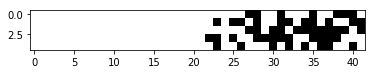

Predicted


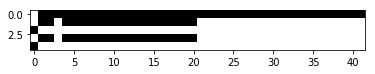

L
Autograd ArrayBox with value [[ 0.          0.10748518  0.08252959  0.06588727  0.05572926  0.04986255
   0.04658298  0.04478156  0.04379747  0.04325711]
 [ 0.10746245  0.          0.06992896  0.05759439  0.0496758   0.0449599
   0.0422768   0.04078858  0.03997125  0.03952112]
 [ 0.08249979  0.06991901  0.          0.04954682  0.04357049  0.03989973
   0.03777282  0.0365809   0.03592258  0.03555885]
 [ 0.06585889  0.05758281  0.04954408  0.          0.03843623  0.03555117
   0.03385307  0.03289285  0.03235984  0.03206451]
 [ 0.05570516  0.04966606  0.04356828  0.03843631  0.          0.03236596
   0.03095268  0.03014816  0.02969989  0.029451  ]
 [ 0.04984275  0.04495273  0.03989898  0.0355522   0.03236676  0.
   0.02905505  0.02834511  0.02794857  0.0277281 ]
 [ 0.04656655  0.04227186  0.03777349  0.03385511  0.03095431  0.02905583
   0.          0.02725619  0.02688938  0.02668526]
 [ 0.04476745  0.04078526  0.03658265  0.03289567  0.03015044  0.0283465
   0.02725678  0.          0.0

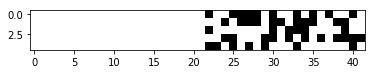

Predicted


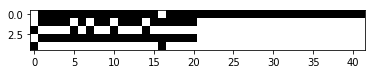

L
Autograd ArrayBox with value [[ 0.          0.10745877  0.0825281   0.06589597  0.05573917  0.04987005
   0.04658744  0.04478349  0.0437976   0.04325597]
 [ 0.10743991  0.          0.06993693  0.057608    0.04968903  0.04497023
   0.04228399  0.04079325  0.03997417  0.03952285]
 [ 0.08250327  0.06992845  0.          0.04956366  0.04358549  0.0399115
   0.03778151  0.03658722  0.03592729  0.0355625 ]
 [ 0.06587224  0.05759794  0.04956111  0.          0.03845066  0.03556252
   0.03386165  0.03289935  0.03236493  0.03206869]
 [ 0.05571896  0.04968038  0.04358321  0.03845056  0.          0.03237545
   0.0309598   0.0301535   0.02970404  0.02945438]
 [ 0.04985342  0.0449637   0.03991039  0.03556315  0.03237605  0.
   0.02906017  0.02834871  0.02795114  0.02772999]
 [ 0.04657362  0.04227932  0.03778158  0.03386311  0.03096109  0.02906081
   0.          0.02725812  0.02689038  0.02668566]
 [ 0.04477161  0.04078995  0.03658821  0.03290147  0.03015534  0.02834987
   0.02725862  0.          0.

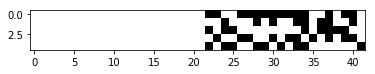

Predicted


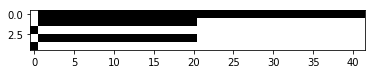

L
Autograd ArrayBox with value [[ 0.          0.10747415  0.08252928  0.06589114  0.05573345  0.04986559
   0.04658469  0.04478226  0.04379752  0.04325673]
 [ 0.10745305  0.          0.0699326   0.05760009  0.04968109  0.04496386
   0.04227944  0.04079026  0.03997234  0.03952183]
 [ 0.08250149  0.06992314  0.          0.04955311  0.04357568  0.0399035
   0.03777539  0.03658264  0.03592383  0.03555981]
 [ 0.06586458  0.05758893  0.04955033  0.          0.03844034  0.03555396
   0.03385485  0.03289397  0.03236057  0.03206503]
 [ 0.05571083  0.04967156  0.04357331  0.03844033  0.          0.0323676
   0.03095349  0.03014844  0.02969988  0.02945084]
 [ 0.04984696  0.04495673  0.03990251  0.03555485  0.03236836  0.
   0.02905505  0.02834469  0.02794792  0.02772732]
 [ 0.04656921  0.04227443  0.03777577  0.03385673  0.03095508  0.02905584
   0.          0.02725528  0.02688827  0.02668405]
 [ 0.04476895  0.04078679  0.03658408  0.03289663  0.03015069  0.02834609
   0.02725588  0.          0.0

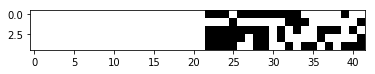

Predicted


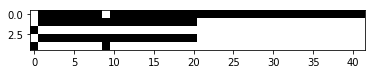

L
Autograd ArrayBox with value [[ 0.          0.10749115  0.08253042  0.06588569  0.05572714  0.04986071
   0.04658168  0.04478084  0.04379732  0.04325747]
 [ 0.10746762  0.          0.0699276   0.0575912   0.04967231  0.04495691
   0.04227454  0.04078702  0.03997032  0.03952071]
 [ 0.08249944  0.06991709  0.          0.0495414   0.04356512  0.03989519
   0.03776926  0.0365782   0.03592058  0.0355574 ]
 [ 0.06585608  0.05757888  0.04953845  0.          0.03842992  0.03554585
   0.03384886  0.03288955  0.03235725  0.03206246]
 [ 0.05570192  0.0496619   0.04356279  0.03843009  0.          0.03236108
   0.03094887  0.03014523  0.02969764  0.02944925]
 [ 0.04983995  0.04494925  0.03989451  0.03554716  0.03236206  0.
   0.02905226  0.02834315  0.02794724  0.02772722]
 [ 0.04656441  0.04226928  0.03777018  0.03385134  0.03095085  0.02905322
   0.          0.02725528  0.02688904  0.02668535]
 [ 0.04476597  0.04078349  0.03658033  0.03289295  0.03014799  0.02834483
   0.02725598  0.          0

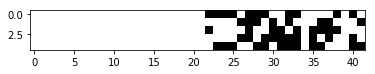

Predicted


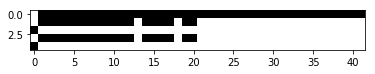

L
Autograd ArrayBox with value [[ 0.          0.10765372  0.0825501   0.06584443  0.05567726  0.04982415
   0.04656301  0.04477789  0.04380661  0.04327409]
 [ 0.10759485  0.          0.06985762  0.05747543  0.04954997  0.04484744
   0.04218242  0.04071014  0.03990515  0.03946089]
 [ 0.08247089  0.06983027  0.          0.04935979  0.0433775   0.03971798
   0.03760679  0.03642885  0.03578128  0.03542125]
 [ 0.06576608  0.05744046  0.04934865  0.          0.03820348  0.0353276
   0.0336427   0.03269427  0.03217028  0.03187733]
 [ 0.05560792  0.0495172   0.04336474  0.03820062  0.          0.03213011
   0.0307277   0.02993308  0.0294924   0.02924518]
 [ 0.04976458  0.04481983  0.03970735  0.03532556  0.03213055  0.
   0.02883225  0.02813071  0.02774069  0.02752147]
 [ 0.04651123  0.04215976  0.03759901  0.03364245  0.03072953  0.02883353
   0.          0.02704854  0.02668751  0.02648436]
 [ 0.04473148  0.04069118  0.03642343  0.03269565  0.02993622  0.0281332
   0.02704972  0.          0.0

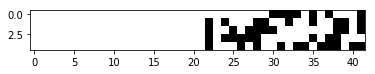

Predicted


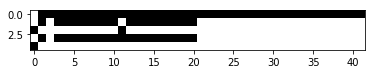

L
Autograd ArrayBox with value [[ 0.          0.10748067  0.08253032  0.06588967  0.05573142  0.04986384
   0.04658346  0.04478151  0.04379714  0.0432566 ]
 [ 0.10745852  0.          0.06993221  0.05759787  0.04967817  0.04496092
   0.04227675  0.04078785  0.03997018  0.03951984]
 [ 0.08250104  0.06992213  0.          0.04954989  0.04357194  0.03989968
   0.0377717   0.03657912  0.03592047  0.03555658]
 [ 0.06586152  0.05758575  0.04954672  0.          0.03843601  0.03554964
   0.03385067  0.03288994  0.03235669  0.03206126]
 [ 0.05570723  0.04966752  0.04356896  0.03843577  0.          0.03236312
   0.03094918  0.0301443   0.02969588  0.02944693]
 [ 0.0498437   0.04495259  0.03989796  0.03555018  0.03236375  0.
   0.02905082  0.02834063  0.027944    0.0277235 ]
 [ 0.04656651  0.04227049  0.03777127  0.03385212  0.03095058  0.02905153
   0.          0.02725137  0.02688449  0.02668037]
 [ 0.04476677  0.04078312  0.03657972  0.03289214  0.03014632  0.02834192
   0.02725193  0.          0

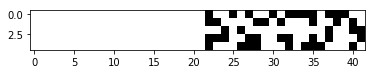

Predicted


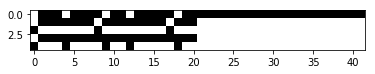

L
Autograd ArrayBox with value [[ 0.          0.10745876  0.08252816  0.06589602  0.05573916  0.04986999
   0.04658735  0.04478339  0.04379749  0.04325584]
 [ 0.10743995  0.          0.06993724  0.05760829  0.04968922  0.04497032
   0.04228399  0.0407932   0.0399741   0.03952275]
 [ 0.08250341  0.0699288   0.          0.04956415  0.04358588  0.03991179
   0.03778171  0.03658738  0.03592742  0.03556262]
 [ 0.06587236  0.05759828  0.0495616   0.          0.03845109  0.03556288
   0.03386195  0.03289963  0.0323652   0.03206896]
 [ 0.05571899  0.04968059  0.0435836   0.03845099  0.          0.03237579
   0.03096011  0.03015381  0.02970435  0.02945469]
 [ 0.04985335  0.04496376  0.03991065  0.03556349  0.03237639  0.
   0.02906047  0.02834902  0.02795146  0.02773032]
 [ 0.0465735   0.04227926  0.03778174  0.03386339  0.03096139  0.02906112
   0.          0.02725844  0.02689072  0.02668601]
 [ 0.04477146  0.04078982  0.03658831  0.03290173  0.03015564  0.02835018
   0.02725894  0.          0

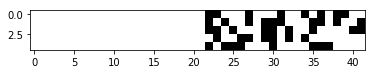

Predicted


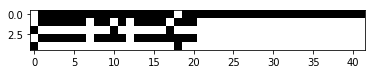

L
Autograd ArrayBox with value [[ 0.          0.10745761  0.08252914  0.06589742  0.05574021  0.04987053
   0.04658747  0.04478325  0.04379724  0.04325557]
 [ 0.1074388   0.          0.06993892  0.05760954  0.0496897   0.04497014
   0.04228336  0.04079233  0.03997312  0.03952176]
 [ 0.08250411  0.06993009  0.          0.04956433  0.04358518  0.03991048
   0.03778005  0.03658555  0.03592554  0.03556075]
 [ 0.06587322  0.0575988   0.04956143  0.          0.03844922  0.03556053
   0.03385937  0.03289695  0.03236251  0.0320663 ]
 [ 0.05571933  0.04968016  0.04358237  0.03844894  0.          0.03237275
   0.03095692  0.03015057  0.02970113  0.02945151]
 [ 0.0498531   0.04496261  0.03990876  0.03556092  0.0323733   0.
   0.02905699  0.02834552  0.02794798  0.02772688]
 [ 0.04657278  0.04227765  0.03777951  0.03386058  0.03095815  0.02905763
   0.          0.02725485  0.02688716  0.02668249]
 [ 0.04477045  0.04078796  0.03658592  0.03289883  0.03015236  0.02834668
   0.02725536  0.          0

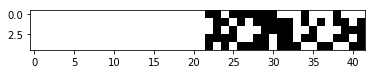

Predicted


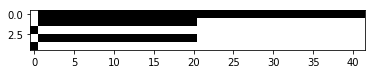

L
Autograd ArrayBox with value [[ 0.          0.10750758  0.08253144  0.0658804   0.05572112  0.04985622
   0.04657912  0.04477991  0.04379758  0.04325854]
 [ 0.10748129  0.          0.069923    0.05758271  0.04966349  0.04494944
   0.04226875  0.04078266  0.03996701  0.03951811]
 [ 0.08249681  0.06991114  0.          0.04952995  0.04355365  0.03988478
   0.03776016  0.03657022  0.03591342  0.0355508 ]
 [ 0.06584726  0.05756861  0.04952635  0.          0.03841687  0.03553364
   0.03383764  0.03287921  0.03234754  0.03205319]
 [ 0.05569283  0.0496513   0.04355041  0.03841671  0.          0.03234831
   0.03093688  0.03013393  0.02968685  0.02943881]
 [ 0.04983285  0.04494014  0.03988313  0.03553446  0.03234912  0.
   0.02904035  0.02833179  0.0279363   0.02771657]
 [ 0.04655962  0.04226199  0.03776012  0.03383959  0.03093861  0.02904121
   0.          0.02724422  0.02687835  0.02667491]
 [ 0.04476307  0.04077776  0.03657142  0.03288205  0.0301364   0.02833334
   0.02724488  0.          0

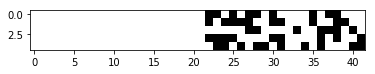

Predicted


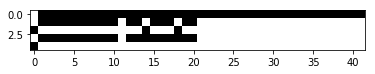

L
Autograd ArrayBox with value [[ 0.          0.10746713  0.08252882  0.06589343  0.05573612  0.04986765
   0.04658594  0.04478281  0.04379753  0.04325634]
 [ 0.10744702  0.          0.06993485  0.0576039   0.04968475  0.04496666
   0.04228129  0.04079133  0.03997285  0.03952194]
 [ 0.08250232  0.06992578  0.          0.04955808  0.04358005  0.03990681
   0.03777766  0.0365841   0.0359247   0.0355603 ]
 [ 0.06586808  0.05759312  0.04955531  0.          0.03844466  0.03555722
   0.03385713  0.03289548  0.03236155  0.03206565]
 [ 0.05571449  0.04967543  0.04357754  0.03844451  0.          0.03237024
   0.03095527  0.03014955  0.02970052  0.02945115]
 [ 0.0498498   0.04495955  0.03990552  0.03555784  0.03237087  0.
   0.02905607  0.02834512  0.02794793  0.02772705]
 [ 0.04657108  0.04227616  0.03777762  0.03385862  0.03095662  0.02905675
   0.          0.02725502  0.02688763  0.02668315]
 [ 0.04476999  0.04078764  0.03658502  0.03289768  0.03015148  0.02834634
   0.02725555  0.          0

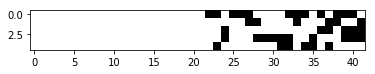

Predicted


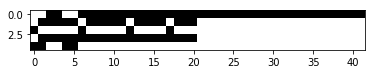

L
Autograd ArrayBox with value [[ 0.          0.10745535  0.08252704  0.06589623  0.05573987  0.04987073
   0.04658794  0.04478378  0.04379766  0.04325578]
 [ 0.10743727  0.          0.06993697  0.05760948  0.04969123  0.04497257
   0.0422862   0.04079527  0.03997599  0.03952445]
 [ 0.0825035   0.06992926  0.          0.0495671   0.04358964  0.03991582
   0.03778572  0.03659125  0.03593114  0.03556617]
 [ 0.065874    0.05760064  0.04956506  0.          0.03845619  0.03556812
   0.03386711  0.03290463  0.03237004  0.03207366]
 [ 0.05572116  0.04968394  0.0435881   0.03845633  0.          0.03238154
   0.03096573  0.03015925  0.02970964  0.02945984]
 [ 0.04985552  0.04496739  0.0399155   0.03556907  0.03238224  0.
   0.02906612  0.02835449  0.02795677  0.0277355 ]
 [ 0.04657546  0.04228283  0.03778657  0.03386891  0.03096713  0.02906679
   0.          0.02726375  0.02689588  0.02669105]
 [ 0.04477319  0.04079322  0.03659299  0.03290709  0.03016121  0.02835568
   0.02726426  0.          0

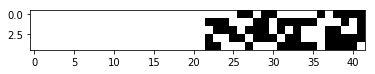

Predicted


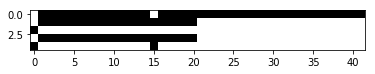

L
Autograd ArrayBox with value [[ 0.          0.1075039   0.0825306   0.06588101  0.05572216  0.04985717
   0.04657981  0.0447803   0.04379766  0.04325834]
 [ 0.10747828  0.          0.06992336  0.05758442  0.0496657   0.0449516
   0.04227064  0.04078424  0.03996828  0.03951911]
 [ 0.08249703  0.06991208  0.          0.04953335  0.04355749  0.03988852
   0.03776359  0.0365733   0.0359162   0.03555332]
 [ 0.06584905  0.05757119  0.04953011  0.          0.03842188  0.03553846
   0.03384211  0.03288331  0.03235135  0.03205675]
 [ 0.05569501  0.04965445  0.04355472  0.03842183  0.          0.03235343
   0.03094164  0.03013834  0.02969097  0.02944271]
 [ 0.04983486  0.04494319  0.03988731  0.0355394   0.03235425  0.
   0.02904491  0.02833603  0.02794028  0.02772035]
 [ 0.04656129  0.04226472  0.03776393  0.03384413  0.03094334  0.02904574
   0.          0.02724813  0.02688201  0.02667839]
 [ 0.04476439  0.04078012  0.03657484  0.03288619  0.03014075  0.02833751
   0.02724876  0.          0.

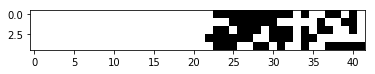

Predicted


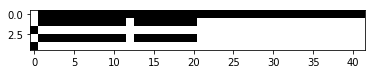

L
Autograd ArrayBox with value [[ 0.          0.10749669  0.08253129  0.06588447  0.05572553  0.04985943
   0.04658087  0.04478043  0.04379719  0.04325755]
 [ 0.10747211  0.          0.0699269   0.05758894  0.04966956  0.04495426
   0.04227218  0.04078493  0.03996843  0.03951896]
 [ 0.08249879  0.06991572  0.          0.04953802  0.04356137  0.03989142
   0.03776563  0.03657471  0.03591719  0.03555409]
 [ 0.06585325  0.05757563  0.04953468  0.          0.03842555  0.03554147
   0.03384454  0.0328853   0.03235305  0.03205829]
 [ 0.05569875  0.04965804  0.04355843  0.03842548  0.          0.0323564
   0.03094423  0.03014064  0.02969307  0.02944469]
 [ 0.04983721  0.04494547  0.03989003  0.0355424   0.03235724  0.
   0.02904749  0.0283384   0.02794249  0.02772248]
 [ 0.04656224  0.04226578  0.03776578  0.03384656  0.03094598  0.02904835
   0.          0.02725044  0.02688421  0.02668051]
 [ 0.04476426  0.04078027  0.03657604  0.03288819  0.0301431   0.02833992
   0.02725109  0.          0.

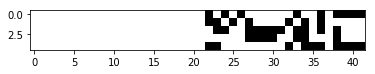

Predicted


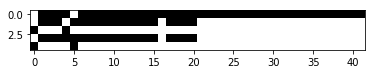

L
Autograd ArrayBox with value [[ 0.          0.10732424  0.08251766  0.06593561  0.05578508  0.04990431
   0.04660648  0.04478906  0.04379255  0.0432456 ]
 [ 0.10733195  0.          0.06999186  0.05769168  0.04977177  0.04503838
   0.0423354   0.04083048  0.04000091  0.03954734]
 [ 0.08252598  0.0699945   0.          0.04968057  0.04369742  0.04000806
   0.03786149  0.0366535   0.03598407  0.03562003]
 [ 0.0659434   0.05769539  0.04968202  0.          0.03857549  0.03567298
   0.03395698  0.03298231  0.03243971  0.03214577]
 [ 0.05579203  0.04977544  0.04369911  0.03857586  0.          0.03248397
   0.03105521  0.03023813  0.02978172  0.02953495]
 [ 0.04991047  0.04504153  0.04000939  0.03567314  0.03248383  0.
   0.02914692  0.02842608  0.02802253  0.0278045 ]
 [ 0.04661206  0.042338    0.03786235  0.03395679  0.03105481  0.02914669
   0.          0.02732597  0.02695293  0.02675145]
 [ 0.04479428  0.04083268  0.03665399  0.03298184  0.03023751  0.02842566
   0.02732579  0.          0

KeyboardInterrupt: 

In [100]:
def loss_fn(pred, target):
    pred = sigmoid(pred)
    one = np.ones_like(pred)
    epsilon = 1.e-20 # to prevent log(0)
    a = target * np.log(pred + epsilon)
    b = (one - target) * np.log(one - pred + epsilon)
    return - (a + b)

dnc = DNCFF(input_size=7, output_size=5, hidden_size=32, R=1, N=10, W=1)
# dnc = DNC(input_size=12, output_size=10, hidden_size=10, R=1, N=10, W=1)
dnc_params = dnc._init_params()

def print_training_prediction(params):
    
    inputs, targets, seqlen = copy_sequence(20, 5)
    result = []
    loss = 0
#     print "Tar: ", targets
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
#         if t >= inputs.shape[0] - seqlen:
        loss = loss + loss_fn(out, targets[np.newaxis, t])
        result.append(out)
    print "Test loss: ", np.sum(loss)
#     print "Tar: ", targets
    result = np.concatenate(result, axis=0)
    print "Target"
    display(targets.T)
    print "Predicted"
    display(np.around(sigmoid(result._value), decimals=0).astype('int').T)
    print "L"
    print(dnc.accessor.states[-1]['L'])
    
    
def training_loss(params, iter):
    loss = 0
    inputs, targets, seqlen = copy_sequence(20, 5)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
#         if t >= inputs.shape[0] - seqlen:
        loss = loss + loss_fn(out, targets[np.newaxis, t])
    return np.sum(loss)

def callback(weights, iter, gradient):
    if iter % 3 == 0:
        print("Iteration", iter, "Train loss:", training_loss(weights, 0))
        print_training_prediction(weights)

# Build gradient of loss function using autograd.
training_loss_grad = grad(training_loss)

print("Training DNC...")
# trained_params = adam(training_loss_grad, dnc_params, step_size=0.001,
#                       num_iters=1000, callback=callback)
trained_params = rmsprop(training_loss_grad, dnc_params, step_size=0.001,
                      num_iters=1000, callback=callback)